<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [38]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [39]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "SalesOneWeekAgo", "SalesTwoWeeksAgo", "SalesThreeWeeksAgo"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [40]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

Base original  --->  (6435, 67) (6435, 67) 
Base de Treino  --->  (4500, 63) (4500,) 
Base de teste   --->  (1935, 63)  (1935,)


In [41]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr.score(X_train, y_train)

0.9261786121572834

In [42]:
predictions = mlr.predict(X_test)
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9631412143265271, 72281.4, 103003.555)

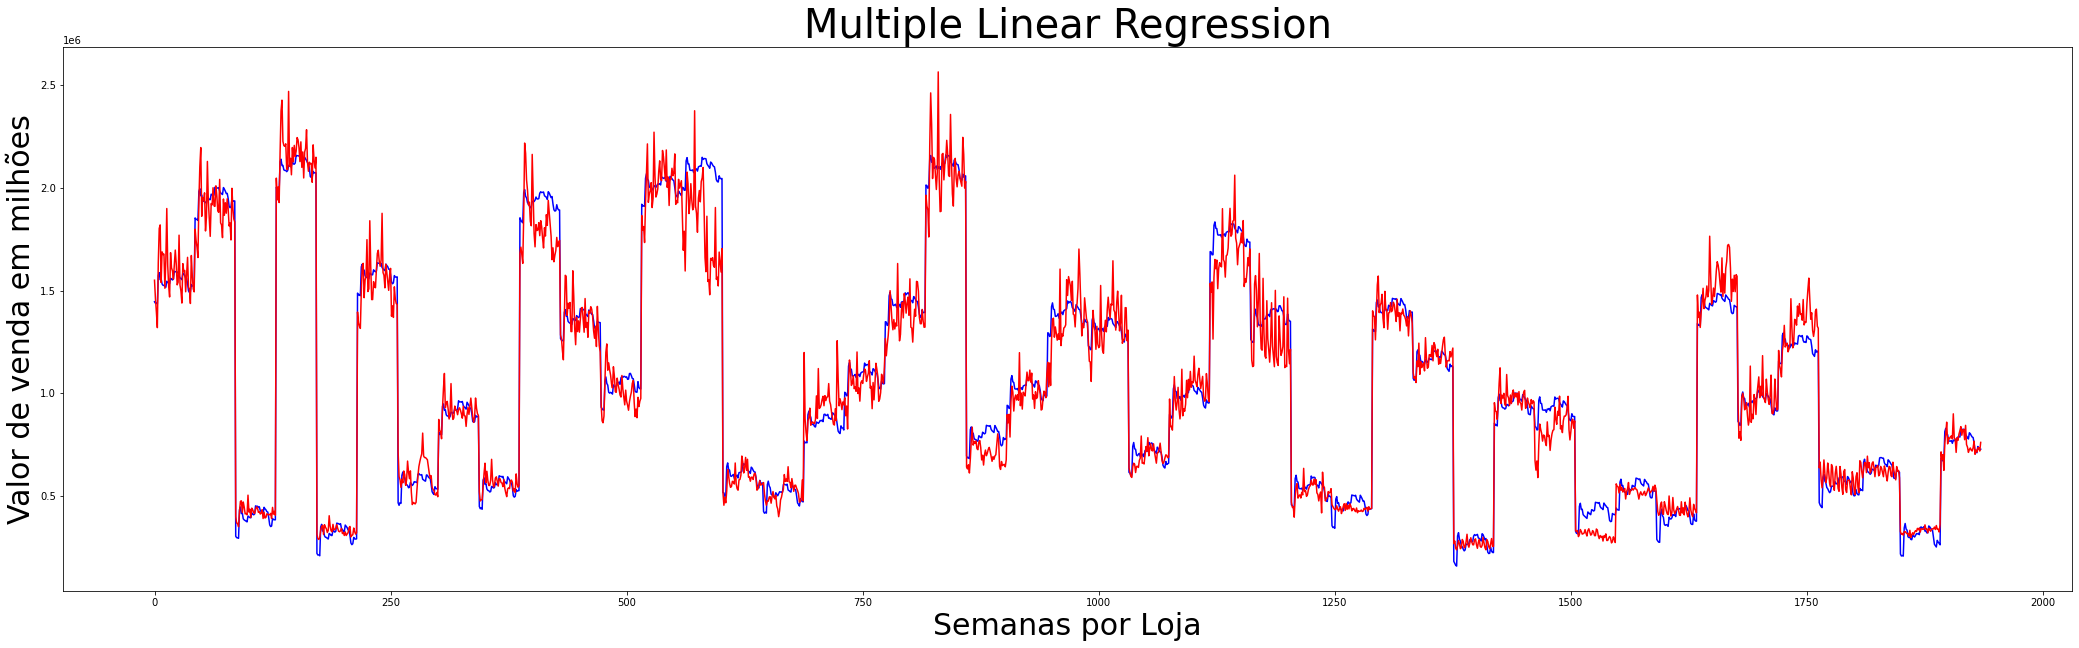

In [43]:
plt.figure(figsize = (36, 10))
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Multiple Linear Regression", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

In [44]:
for i, feature in enumerate(mlr.feature_names_in_):
  print("Feature {}: {}".format(feature, mlr.coef_[i]))


Feature Holiday_Flag: 25422.091796875
Feature Temperature: 821.499755859375
Feature Fuel_Price: -33127.91015625
Feature CPI: 3476.5634765625
Feature Unemployment: -30134.68359375
Feature Day: -574.40625
Feature Month_1: -111550.40625
Feature Month_2: 14458.0703125
Feature Month_3: -25102.61328125
Feature Month_4: -16984.8125
Feature Month_5: -13561.59375
Feature Month_6: 8639.1640625
Feature Month_7: -32190.3984375
Feature Month_8: -14987.8125
Feature Month_9: -79891.71875
Feature Month_10: -64216.328125
Feature Month_11: 96055.1015625
Feature Month_12: 239327.296875
Feature Store_1: 313265.875
Feature Store_2: 716048.3125
Feature Store_3: -859217.0625
Feature Store_4: 1108291.875
Feature Store_5: -957863.125
Feature Store_6: 311724.75
Feature Store_7: -535635.8125
Feature Store_8: -374380.78125
Feature Store_9: -746321.0
Feature Store_10: 1040251.125
Feature Store_11: 101889.1875
Feature Store_12: 270261.875
Feature Store_13: 1072255.0
Feature Store_14: 1028991.75
Feature Store_15: -2

Resultados Loja 1:
82934.21 109600.97


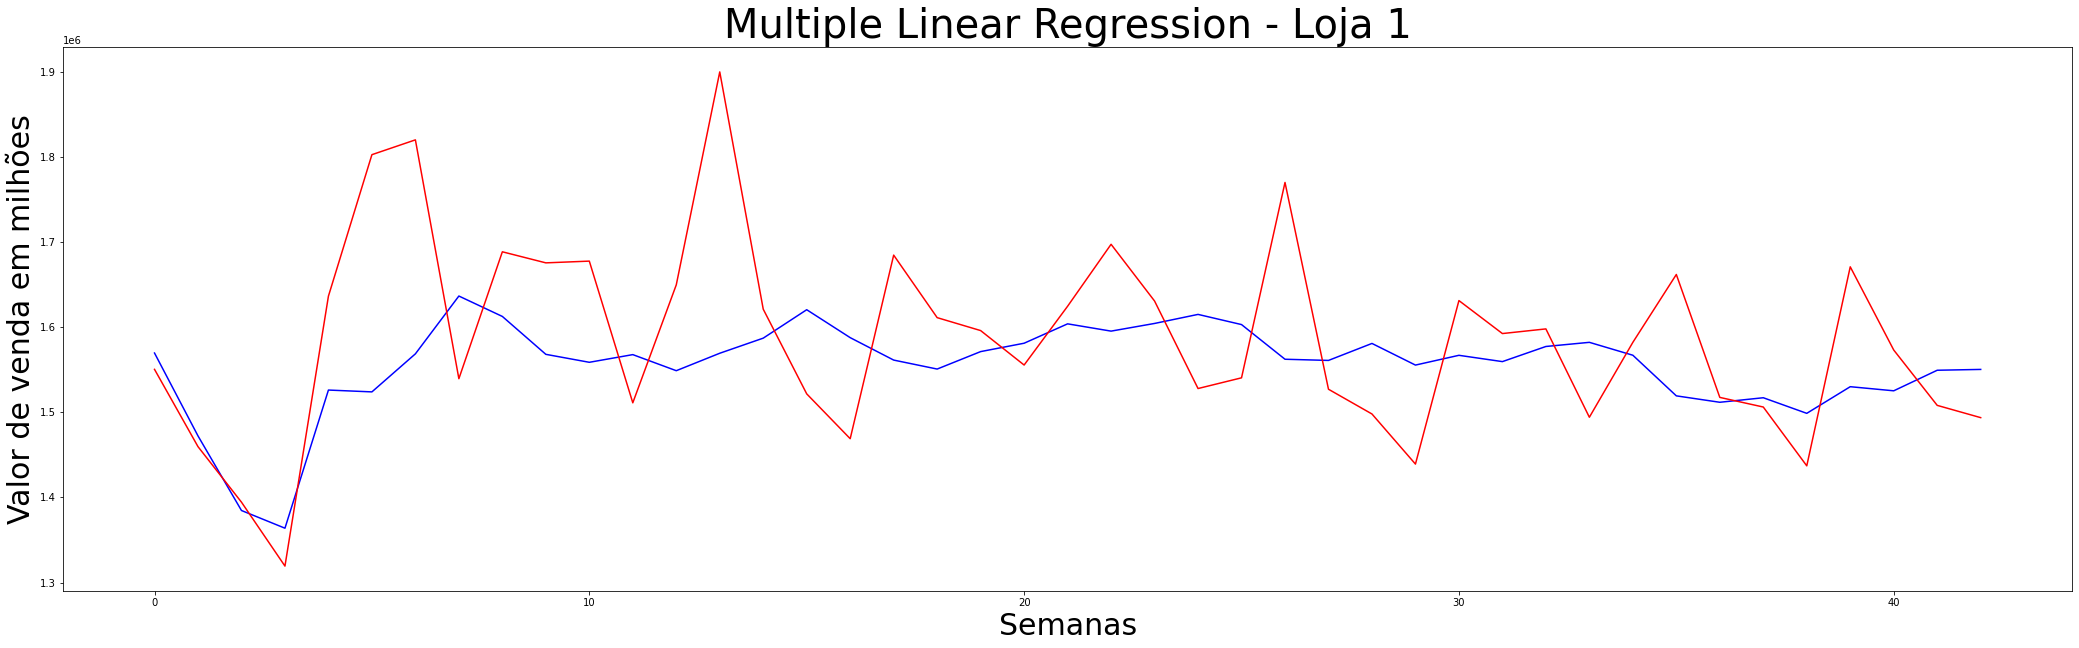

**************************************************
Resultados Loja 2:
87462.65 112085.35


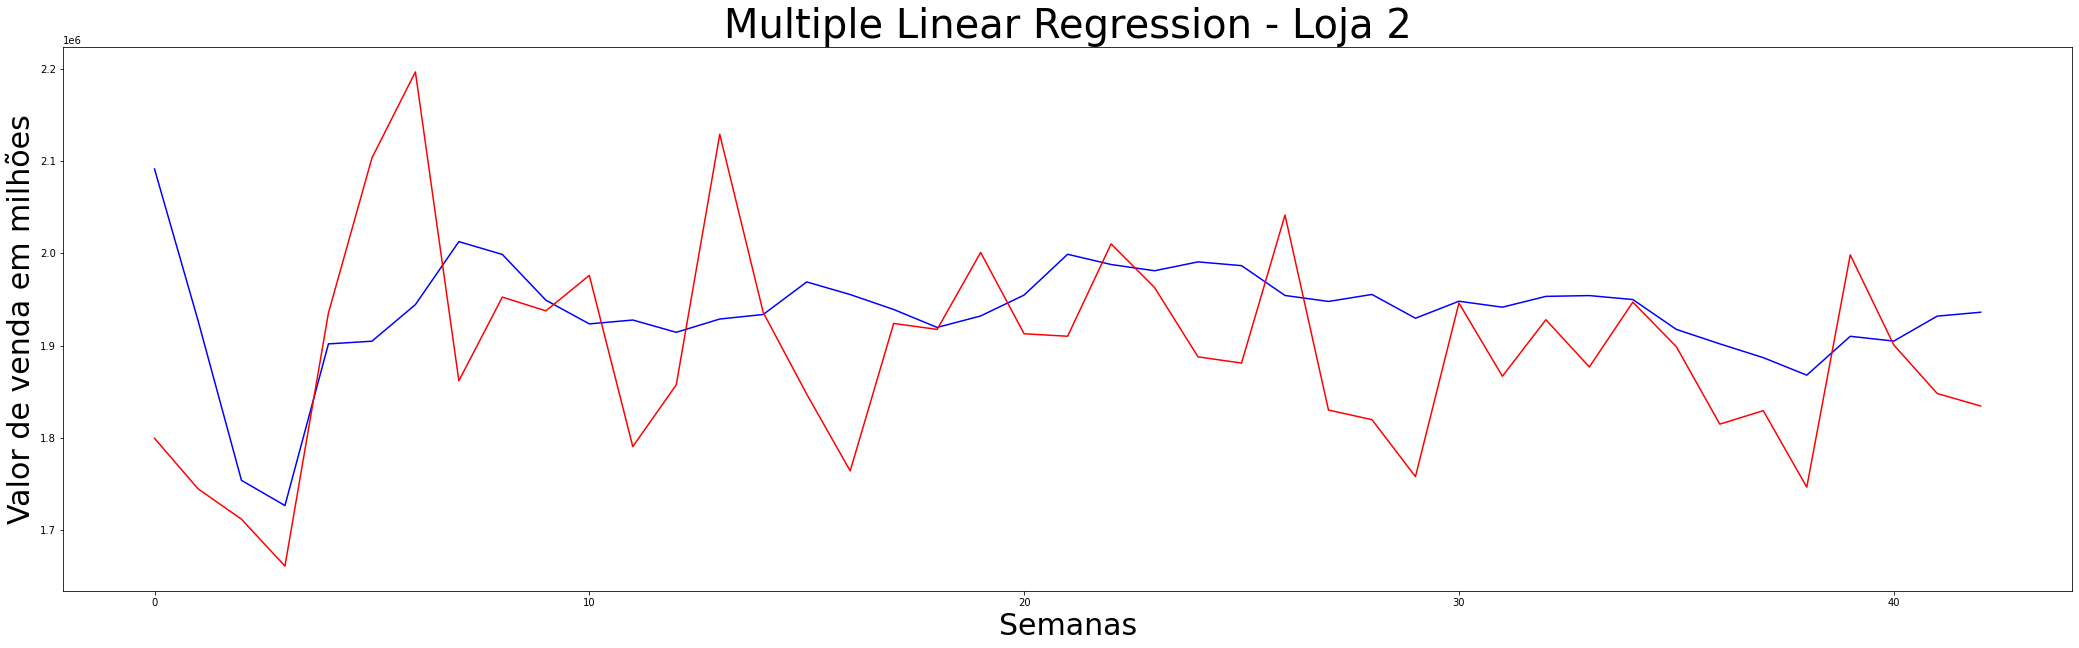

**************************************************
Resultados Loja 3:
31985.262 44124.555


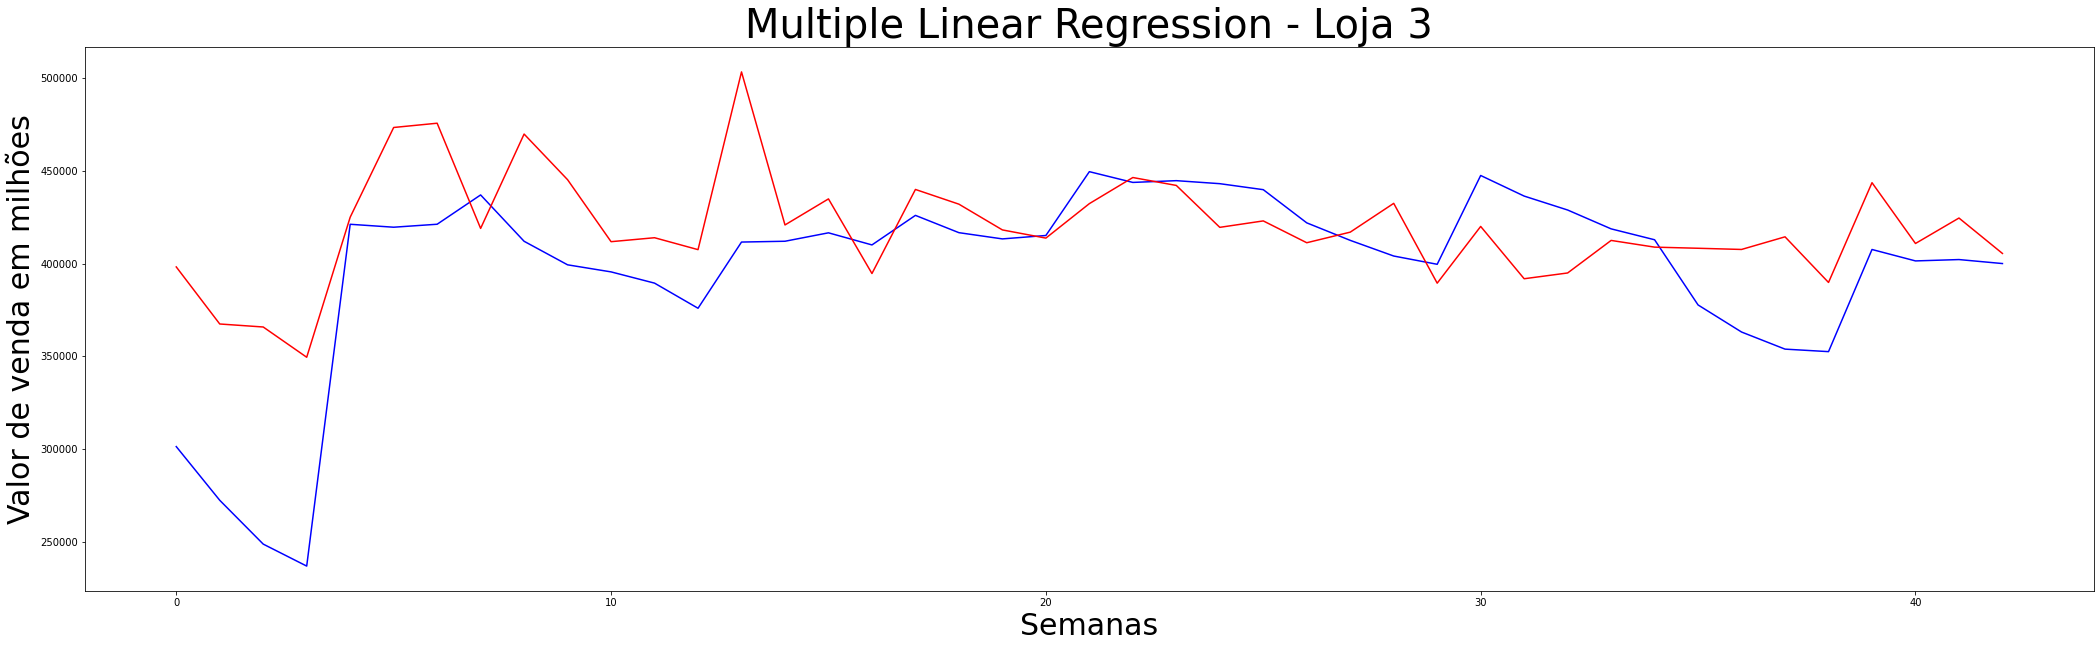

**************************************************
Resultados Loja 4:
72230.76 107146.72


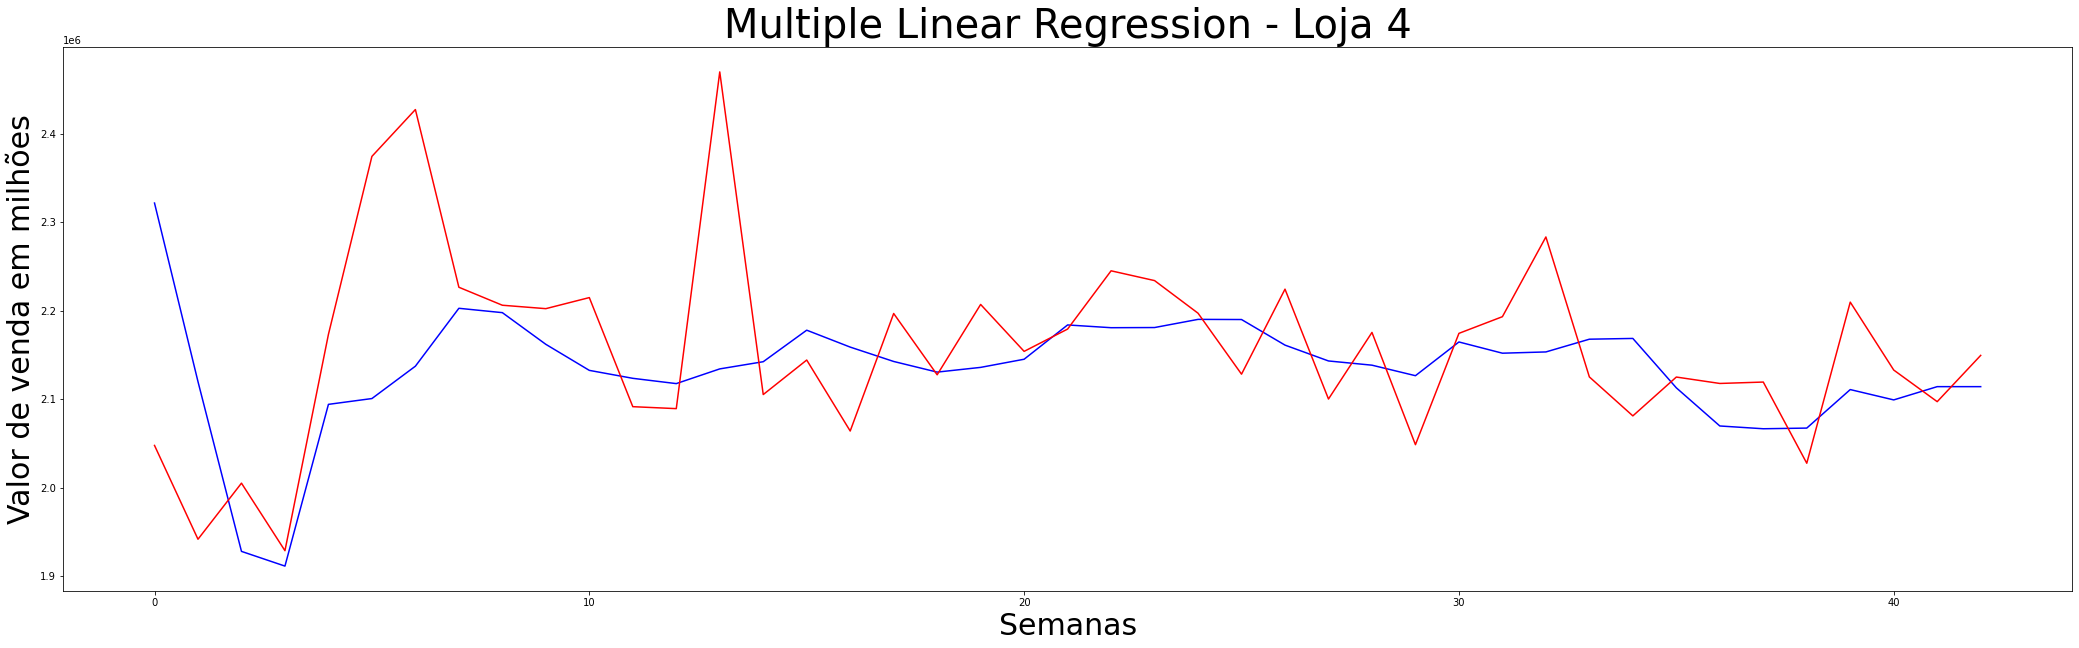

**************************************************
Resultados Loja 5:
30946.639 44330.223


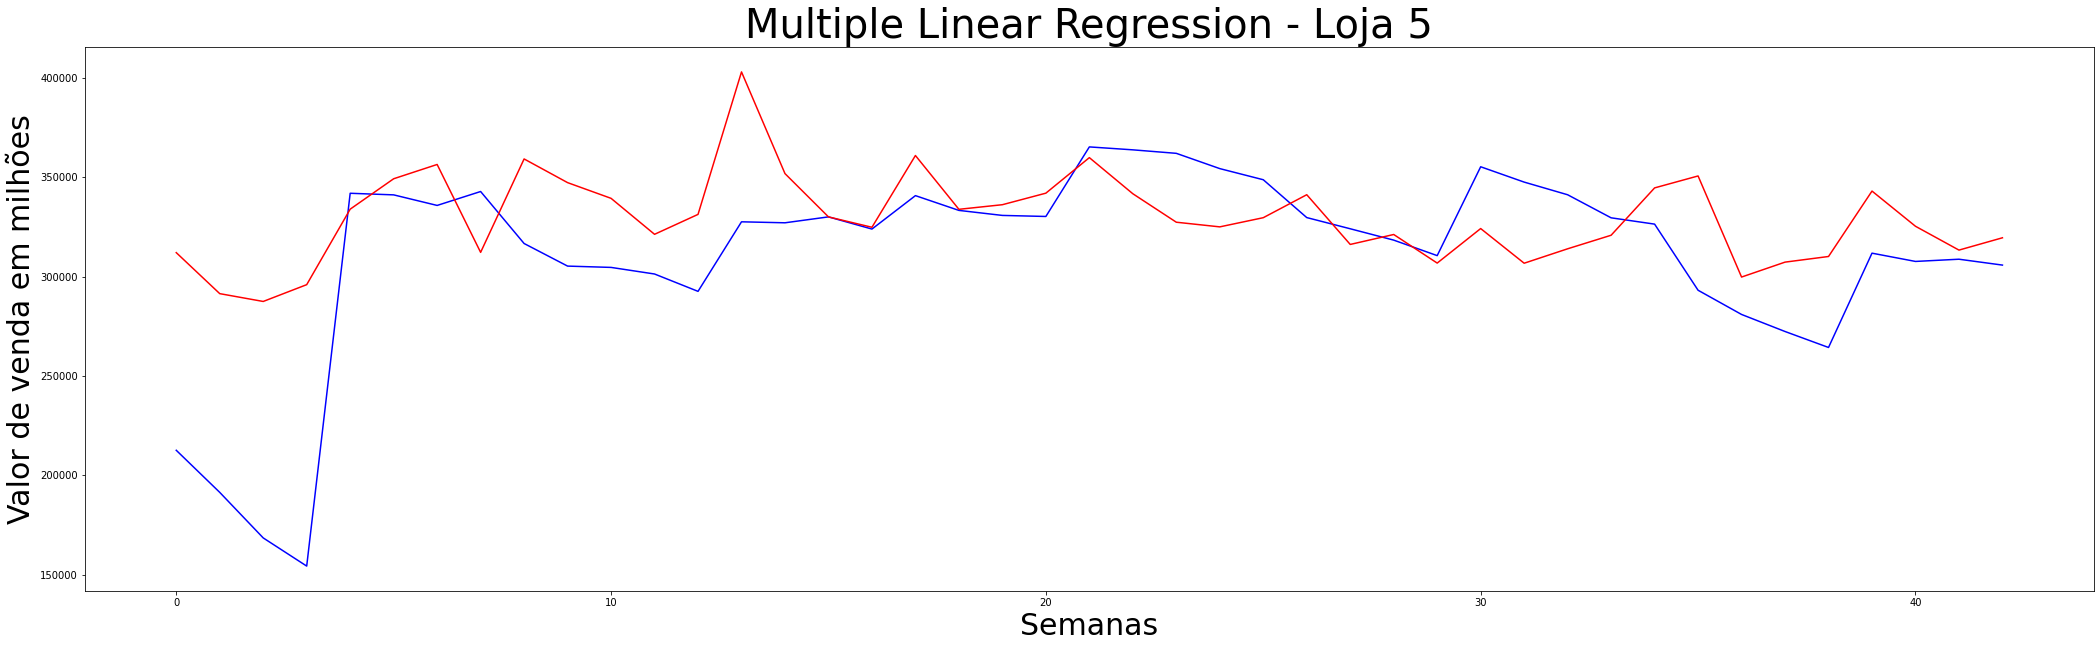

**************************************************
Resultados Loja 6:
85329.17 111092.42


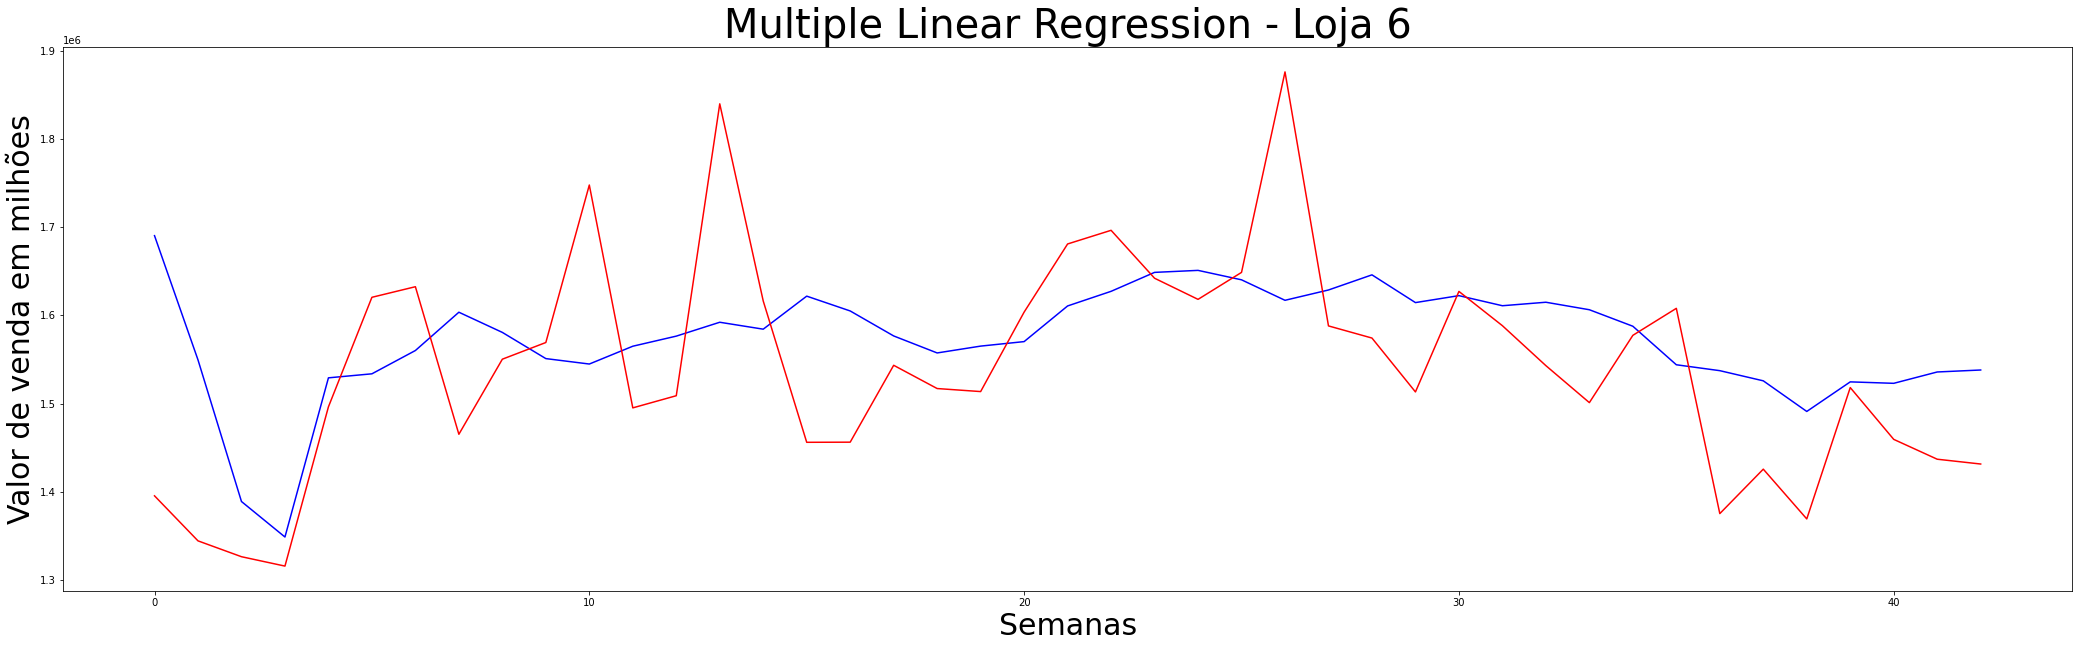

**************************************************
Resultados Loja 7:
52473.938 66235.61


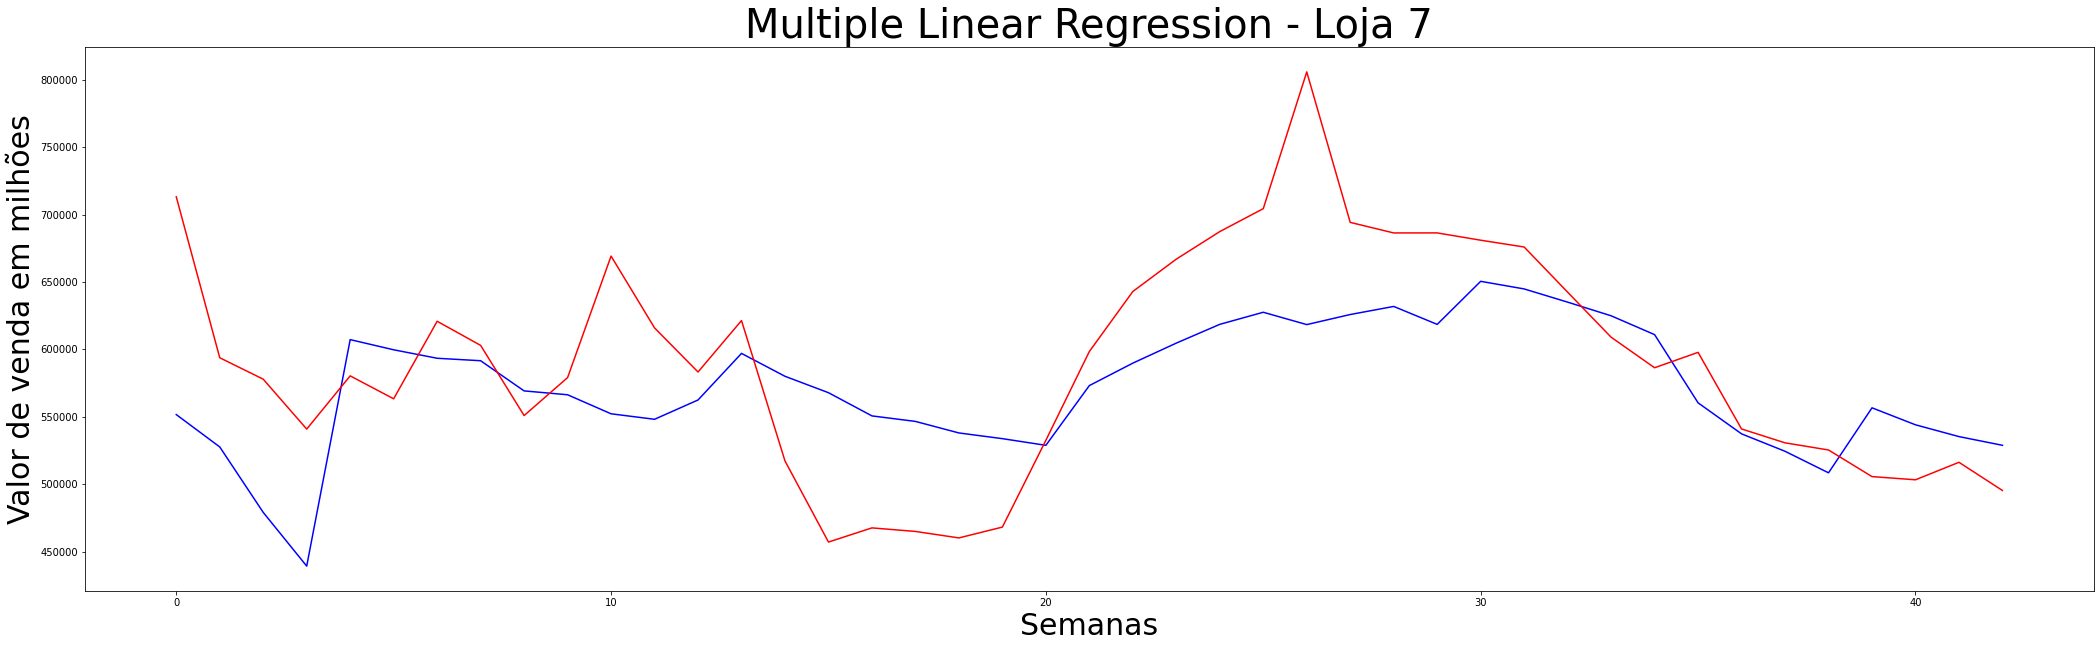

**************************************************
Resultados Loja 8:
36565.293 51217.406


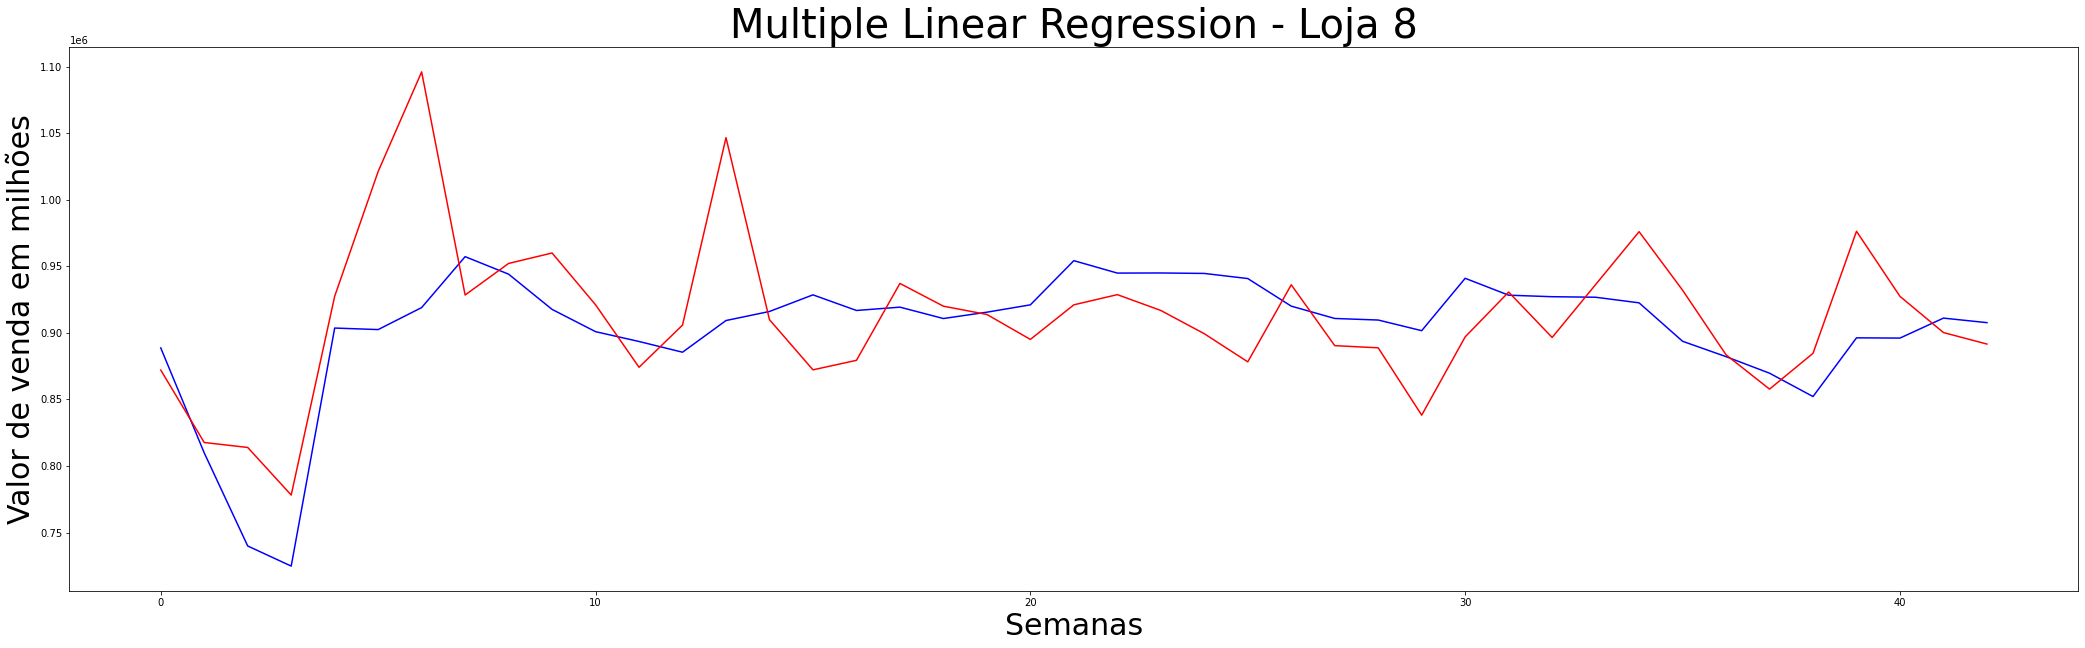

**************************************************
Resultados Loja 9:
33296.223 43318.68


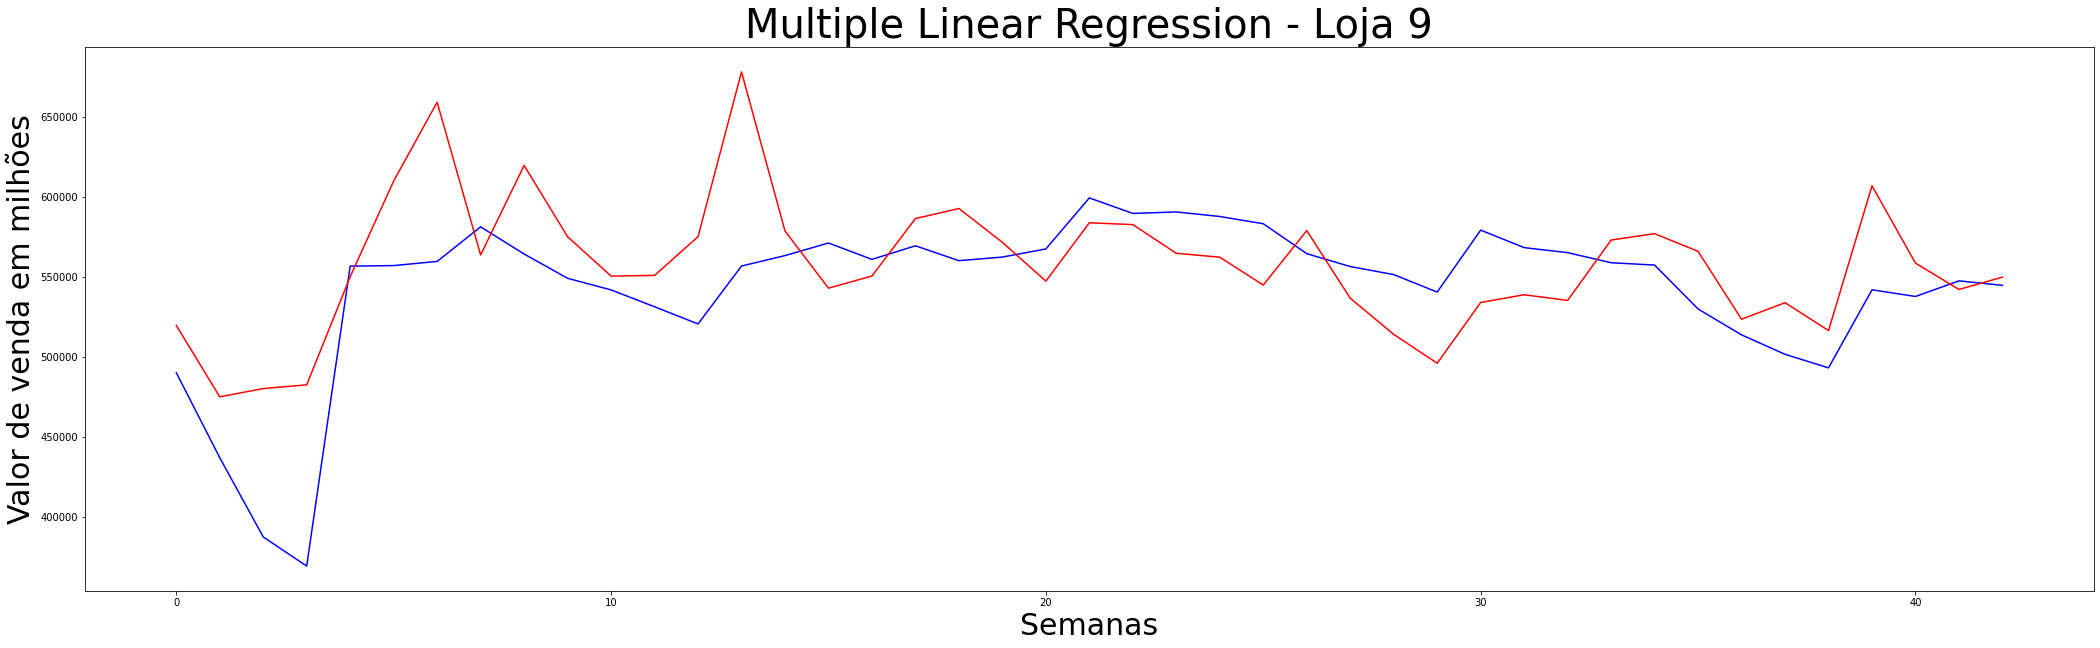

**************************************************
Resultados Loja 10:
126537.49 157333.06


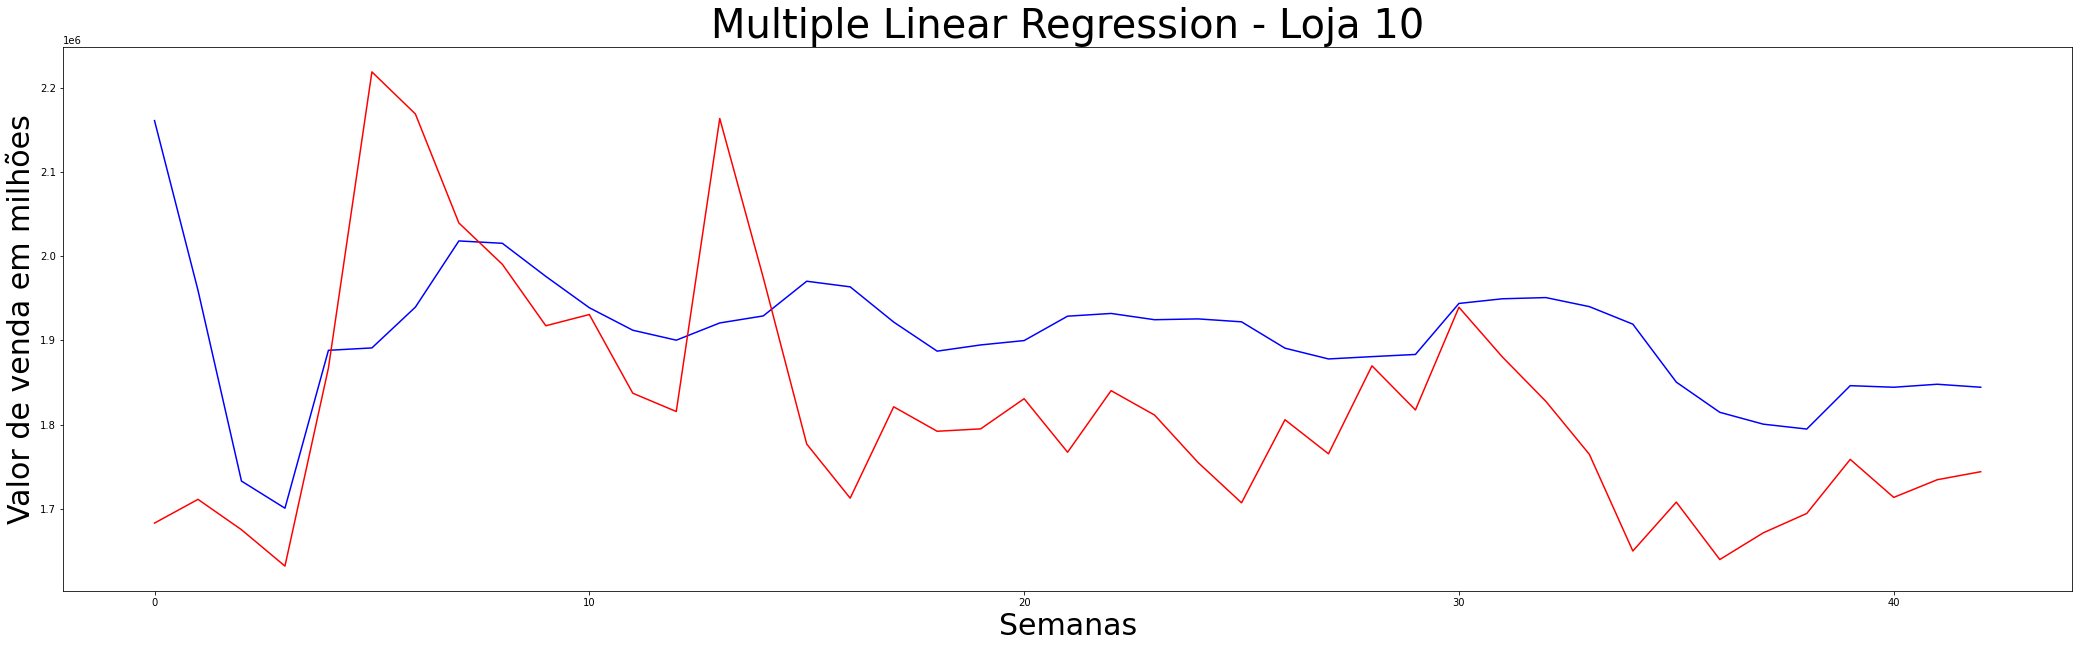

**************************************************
Resultados Loja 11:
64928.086 86690.45


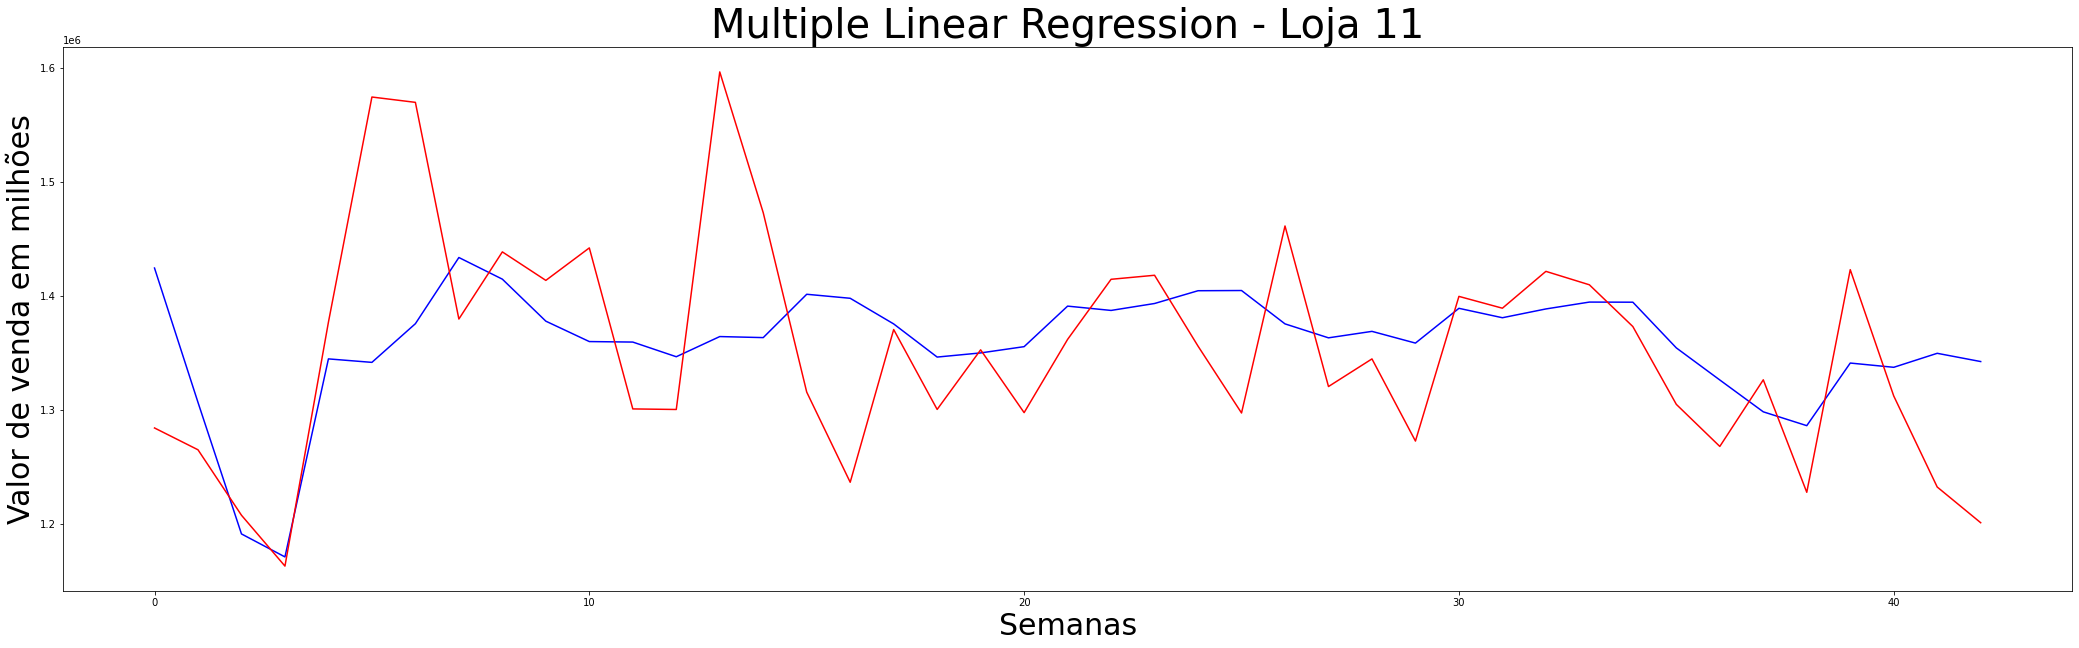

**************************************************
Resultados Loja 12:
61749.594 74624.25


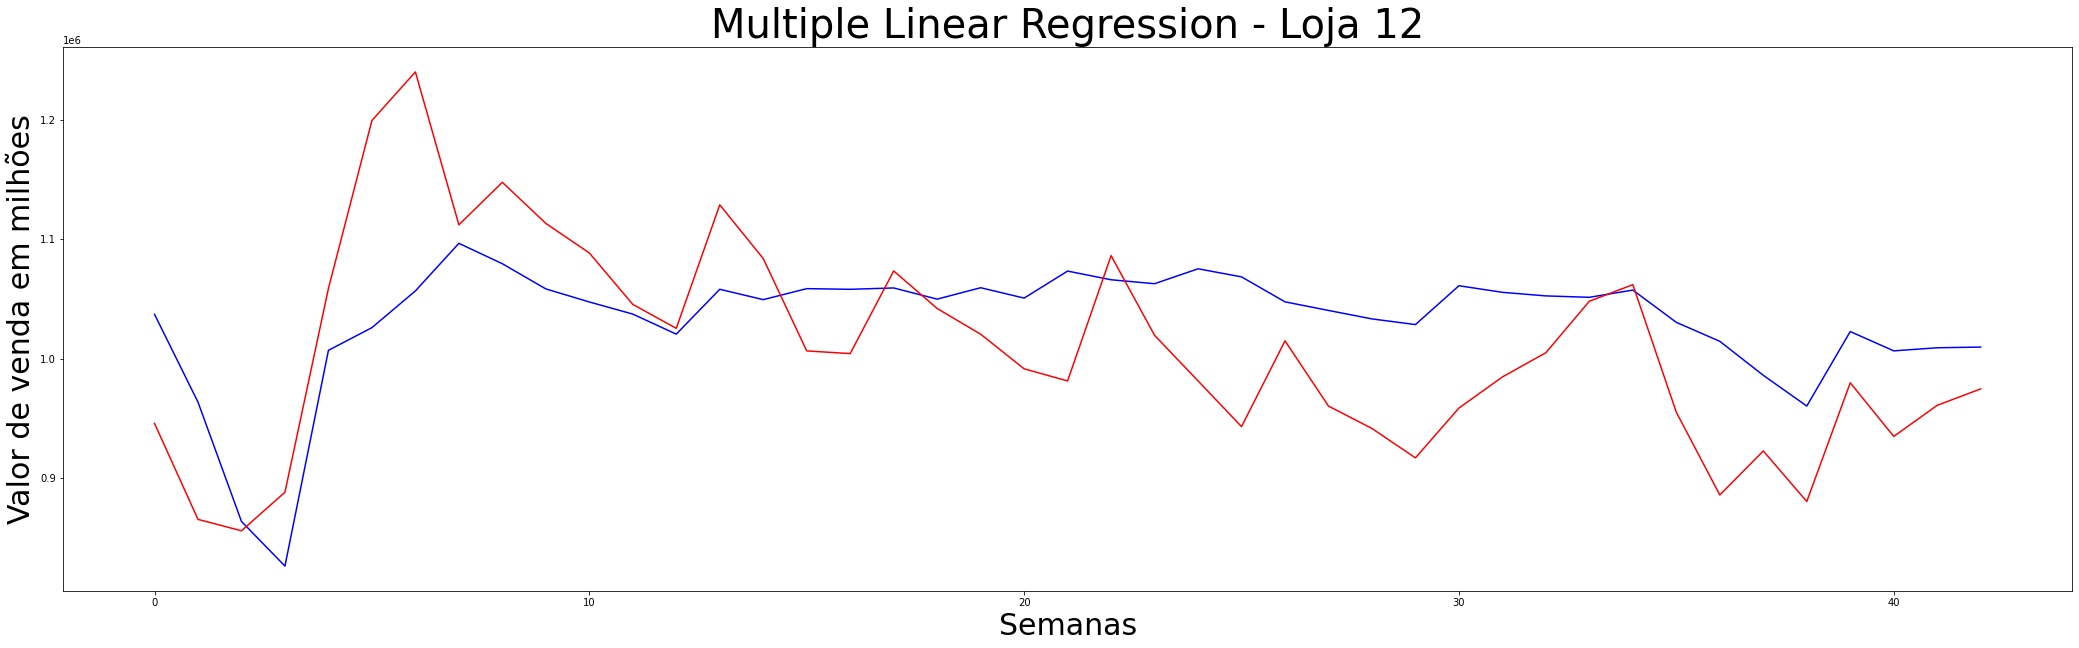

**************************************************
Resultados Loja 13:
76306.055 107489.53


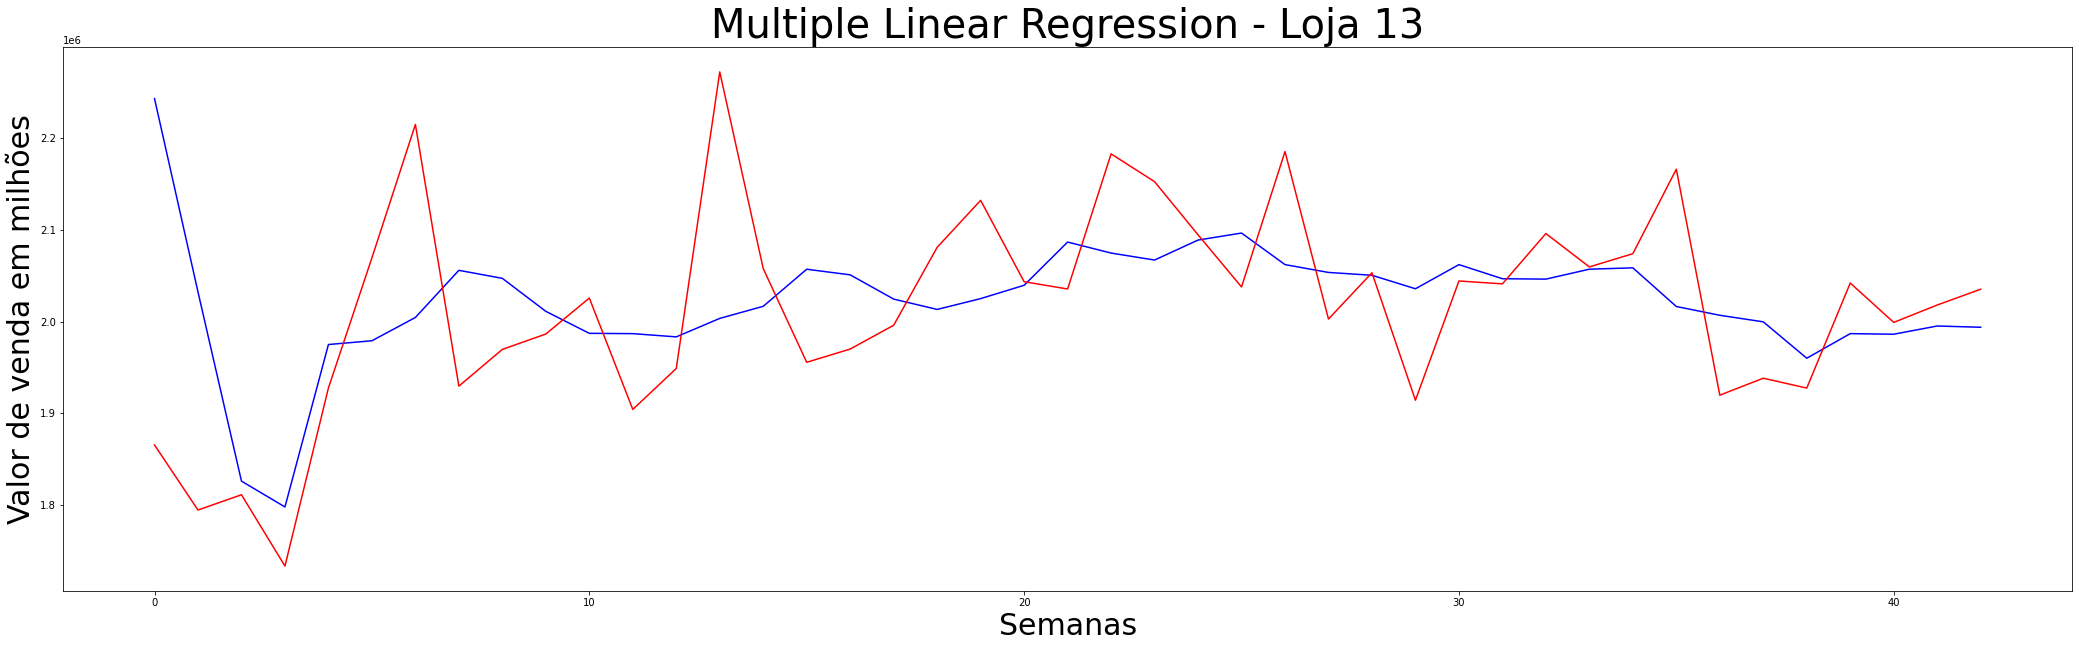

**************************************************
Resultados Loja 14:
211627.38 252235.75


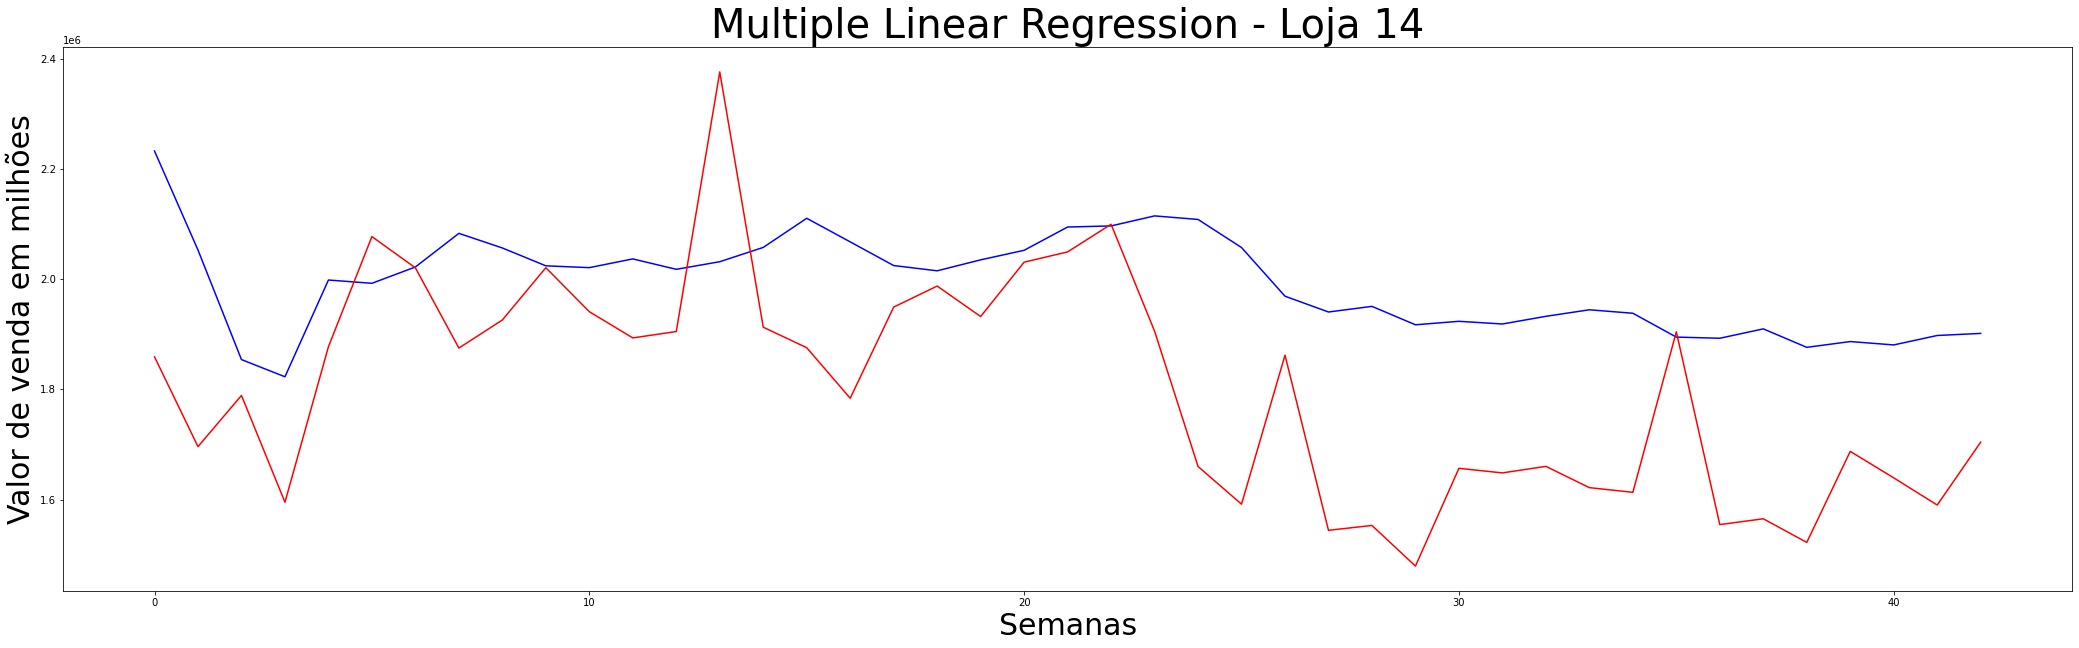

**************************************************
Resultados Loja 15:
32828.812 41302.258


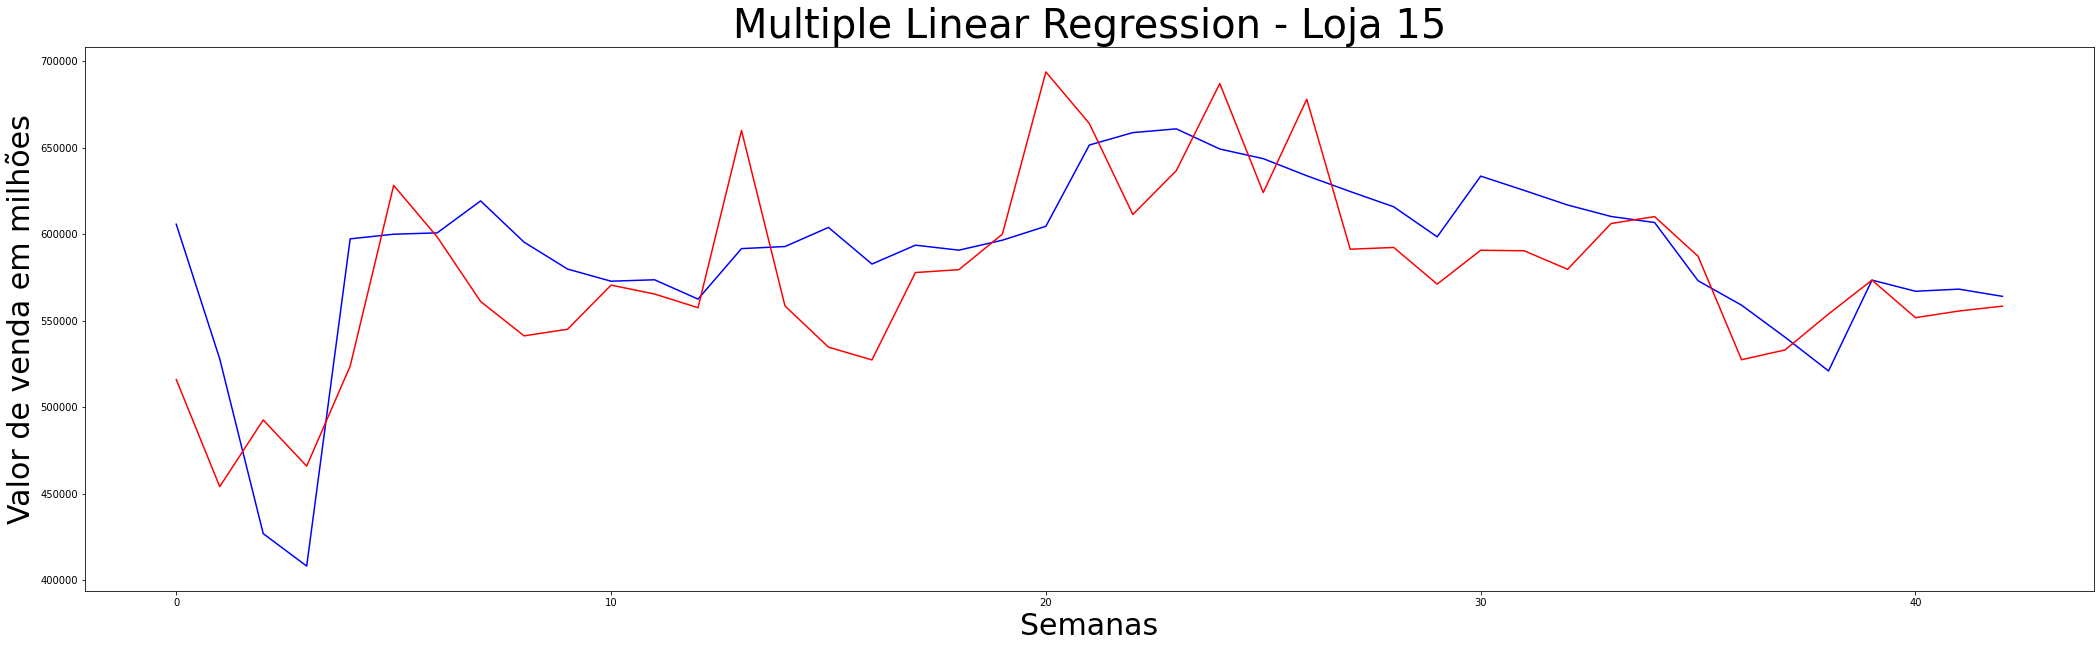

**************************************************
Resultados Loja 16:
34910.984 45145.15


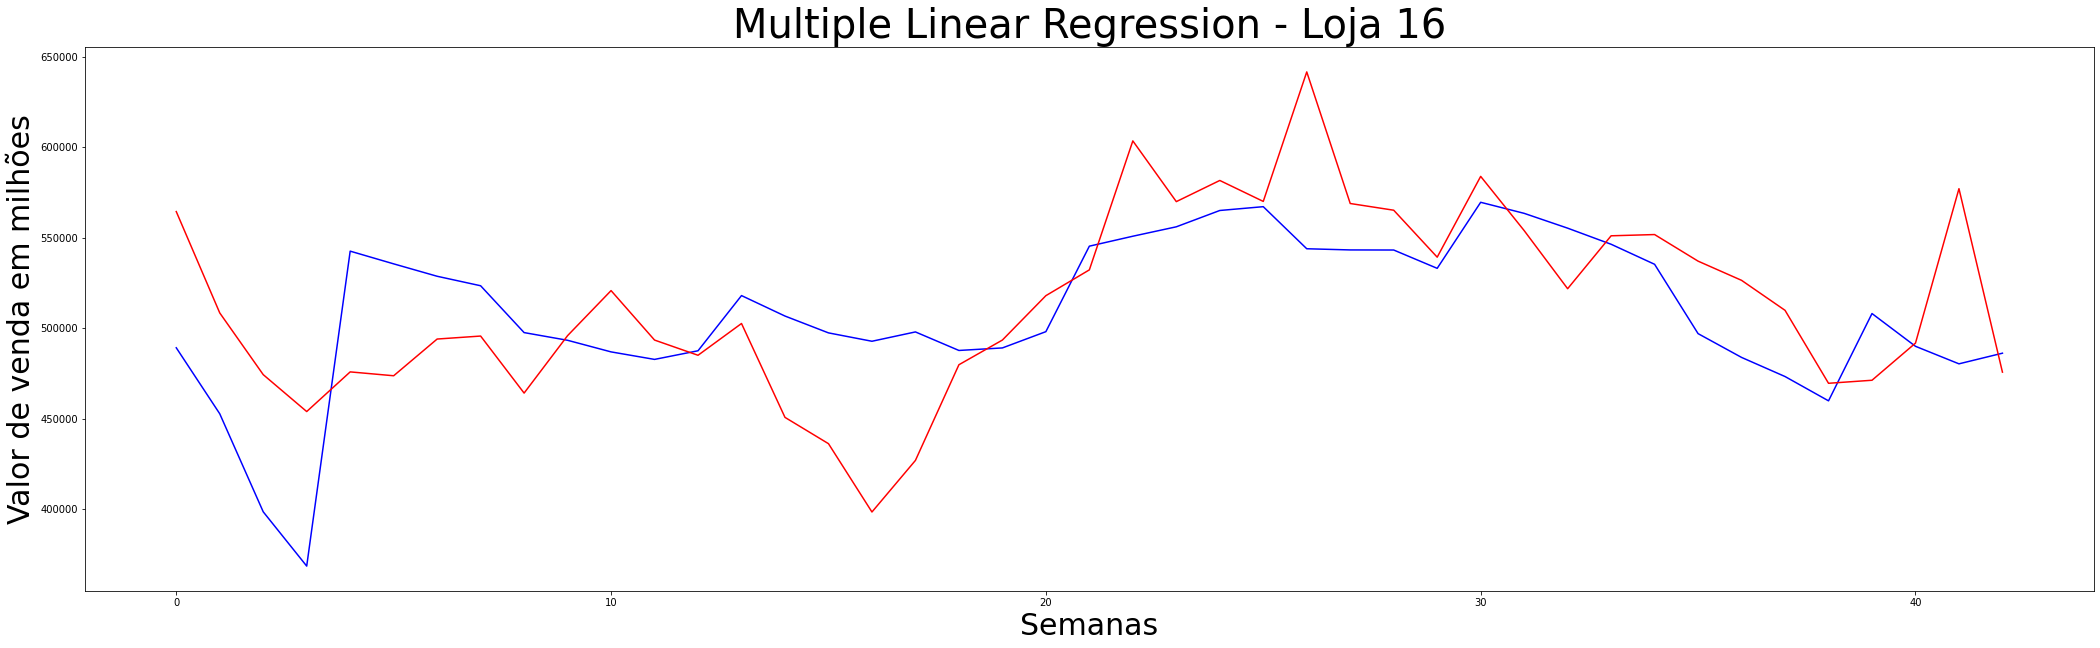

**************************************************
Resultados Loja 17:
68586.07 110735.99


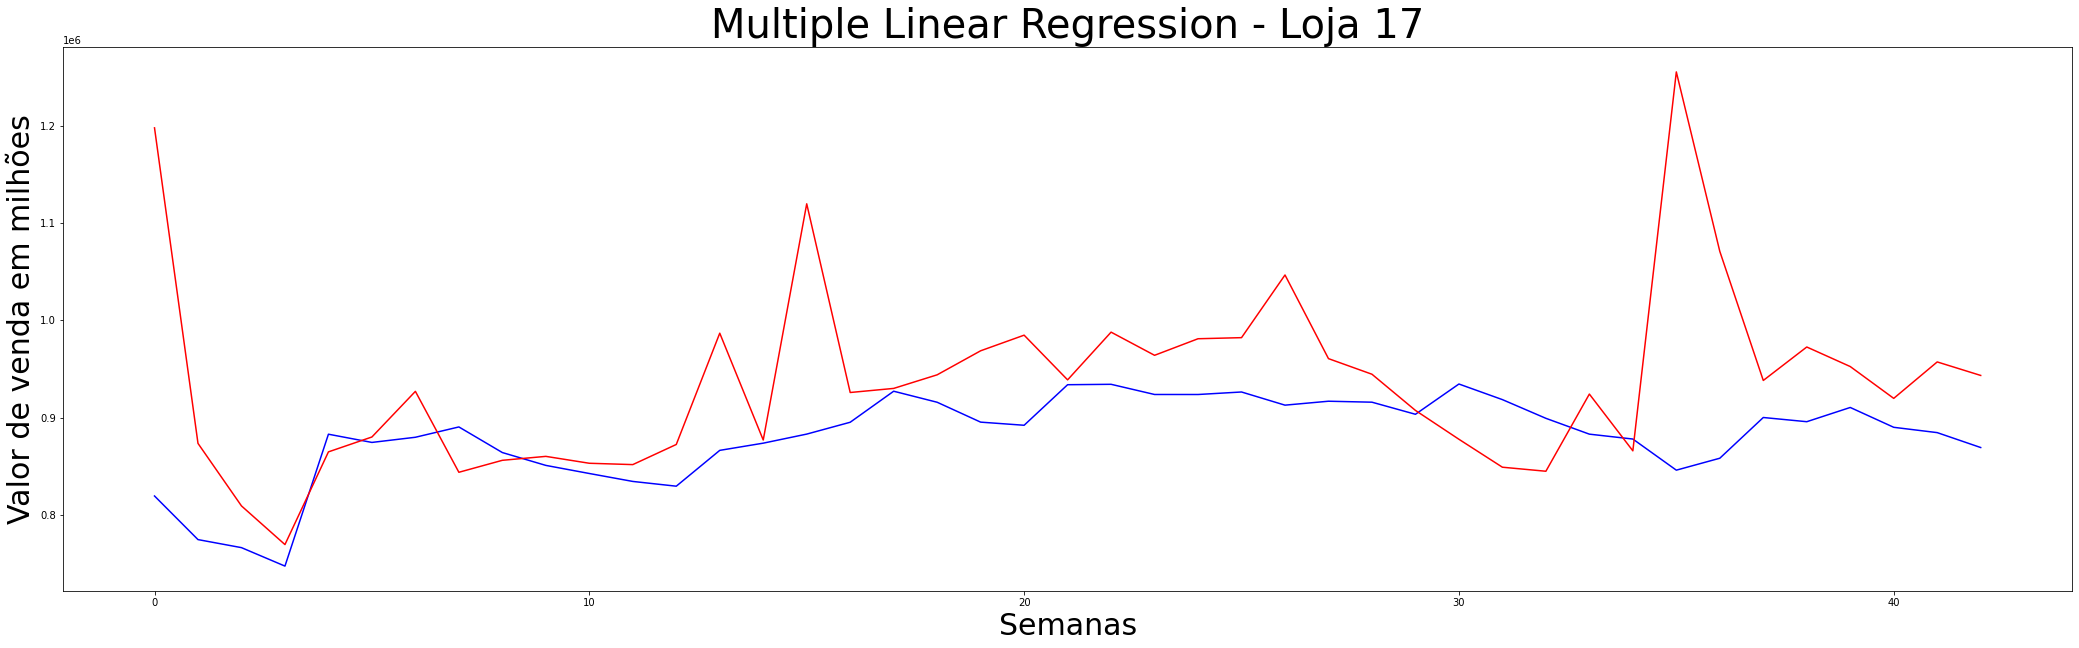

**************************************************
Resultados Loja 18:
56007.016 69039.66


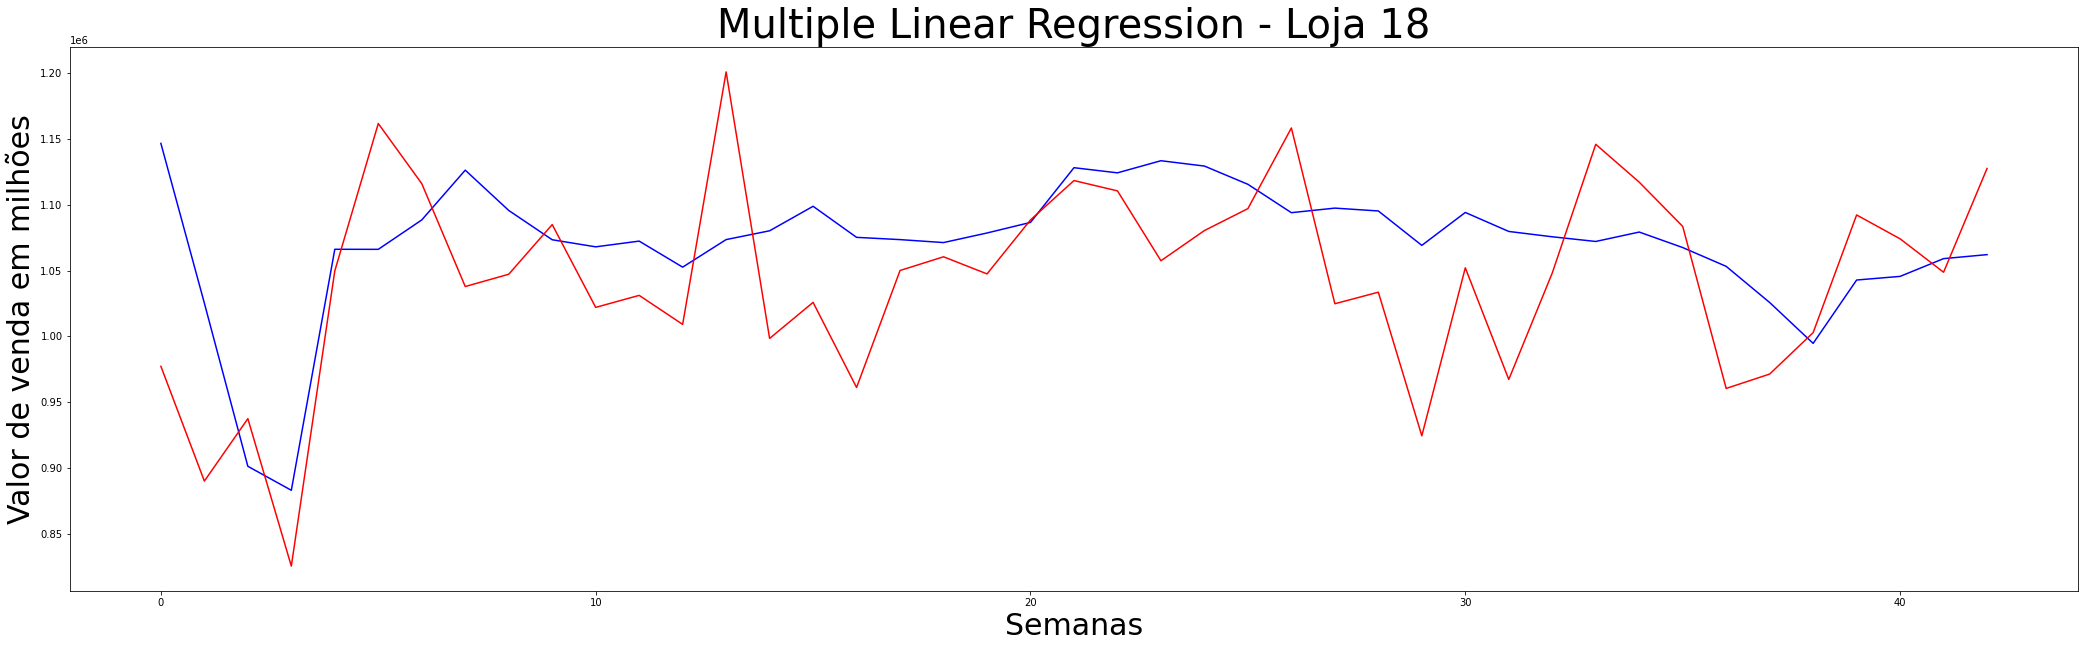

**************************************************
Resultados Loja 19:
78948.49 100415.2


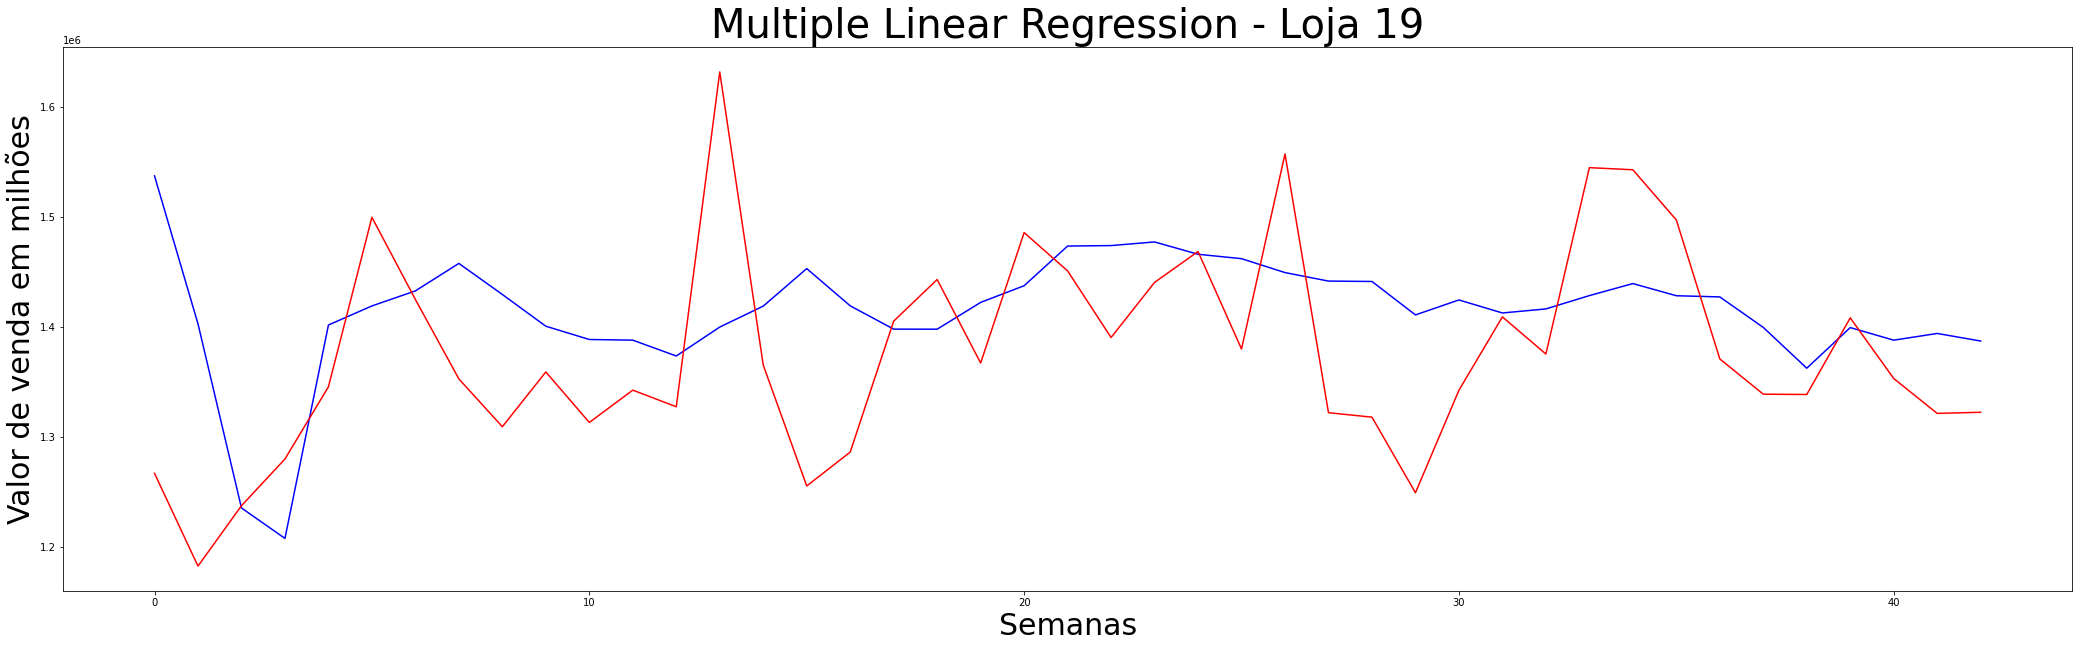

**************************************************
Resultados Loja 20:
113828.945 157977.69


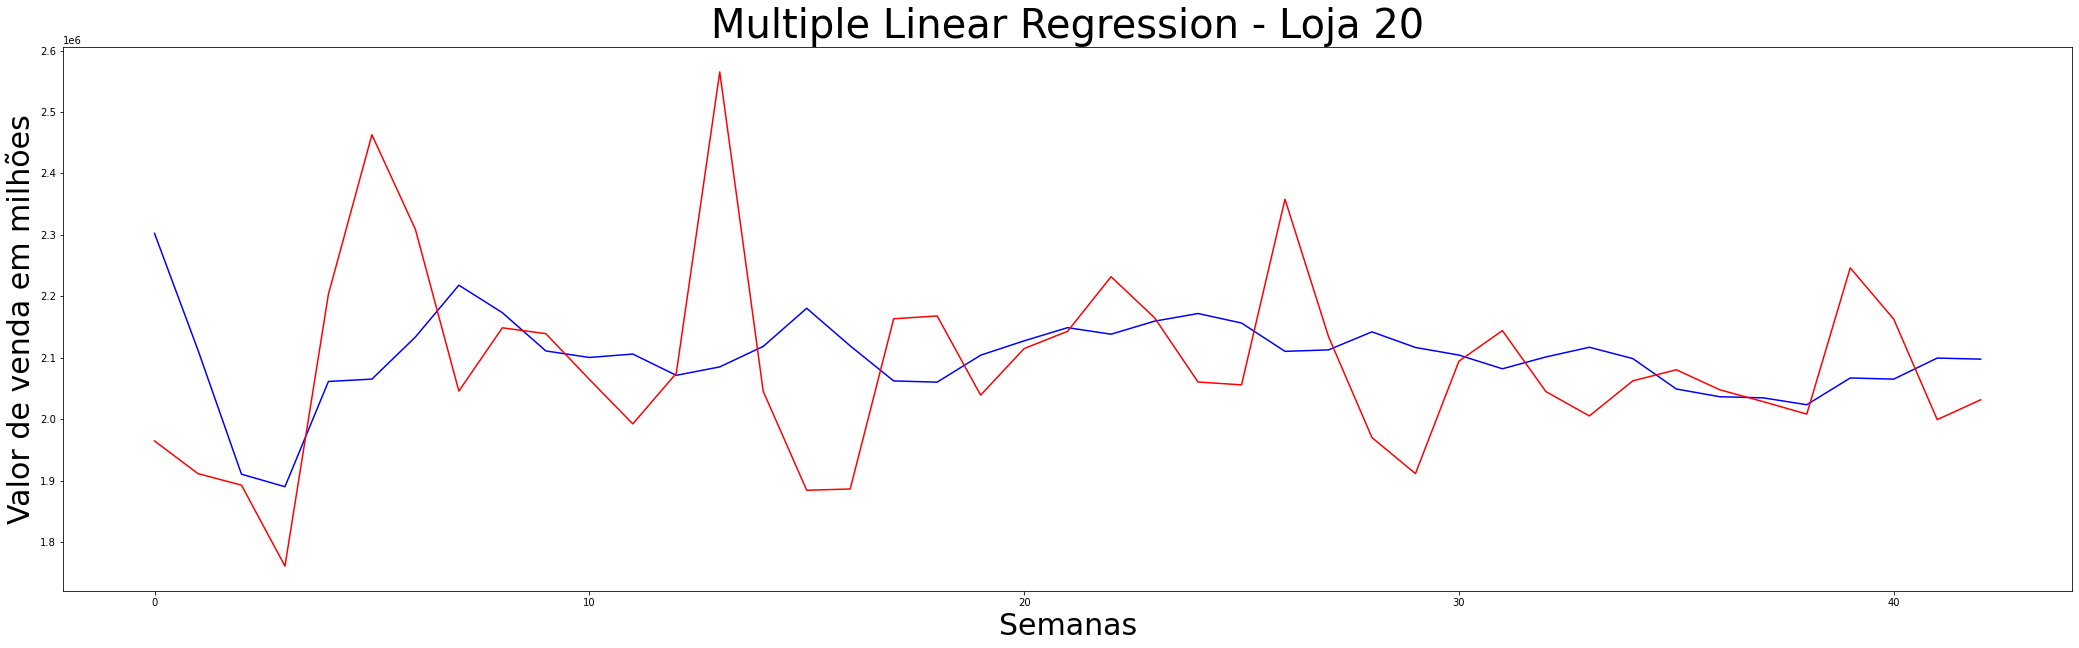

**************************************************
Resultados Loja 21:
64179.855 73990.78


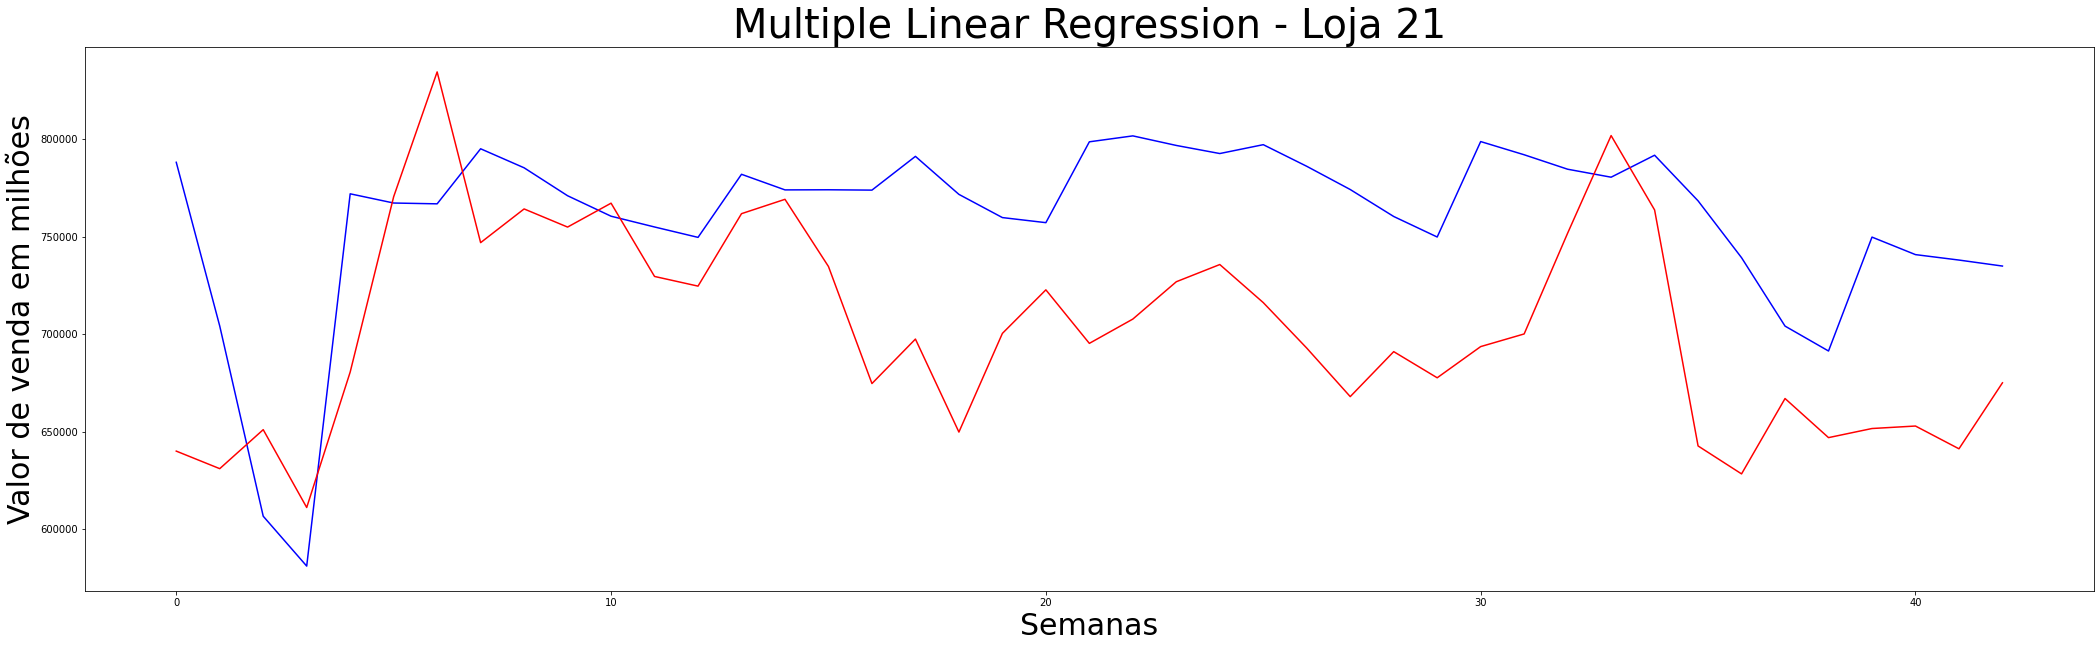

**************************************************
Resultados Loja 22:
48788.344 65460.62


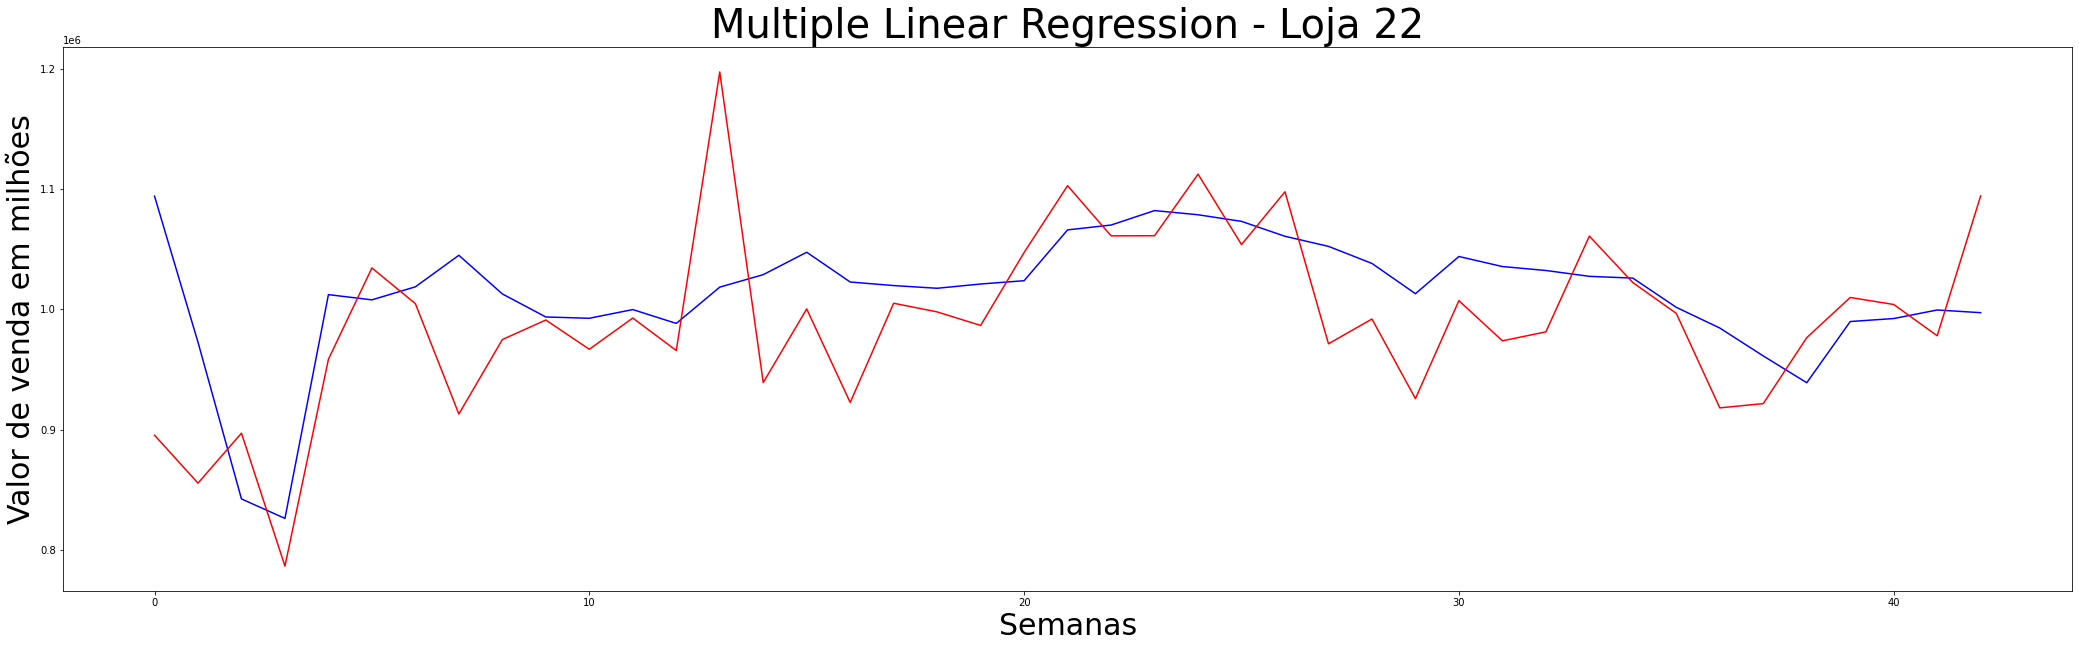

**************************************************
Resultados Loja 23:
86309.03 119570.56


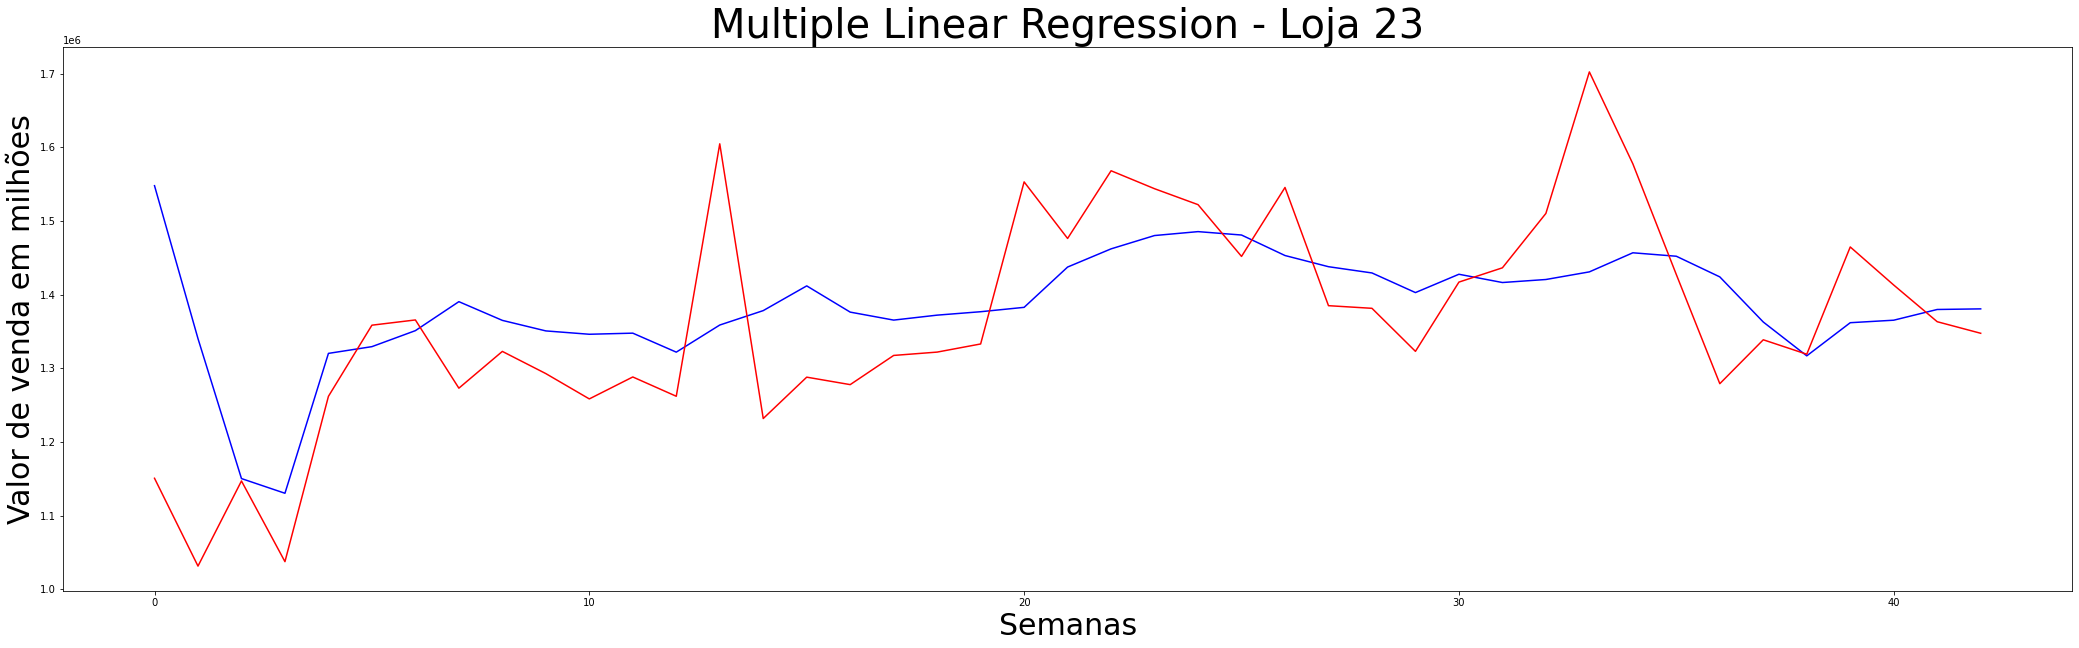

**************************************************
Resultados Loja 24:
70752.1 93699.66


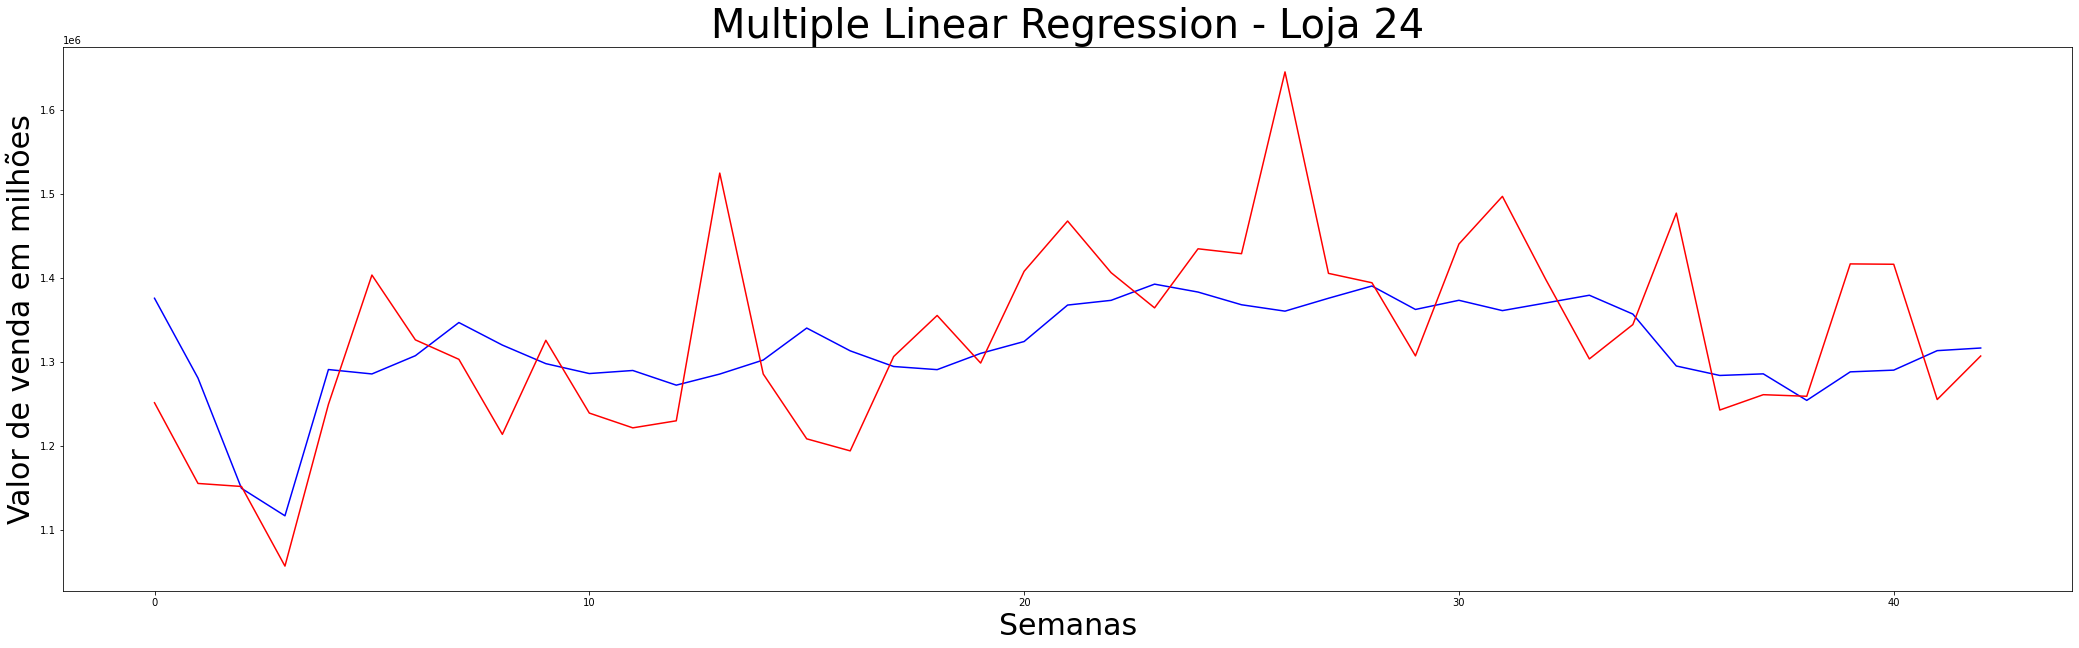

**************************************************
Resultados Loja 25:
33293.38 41129.23


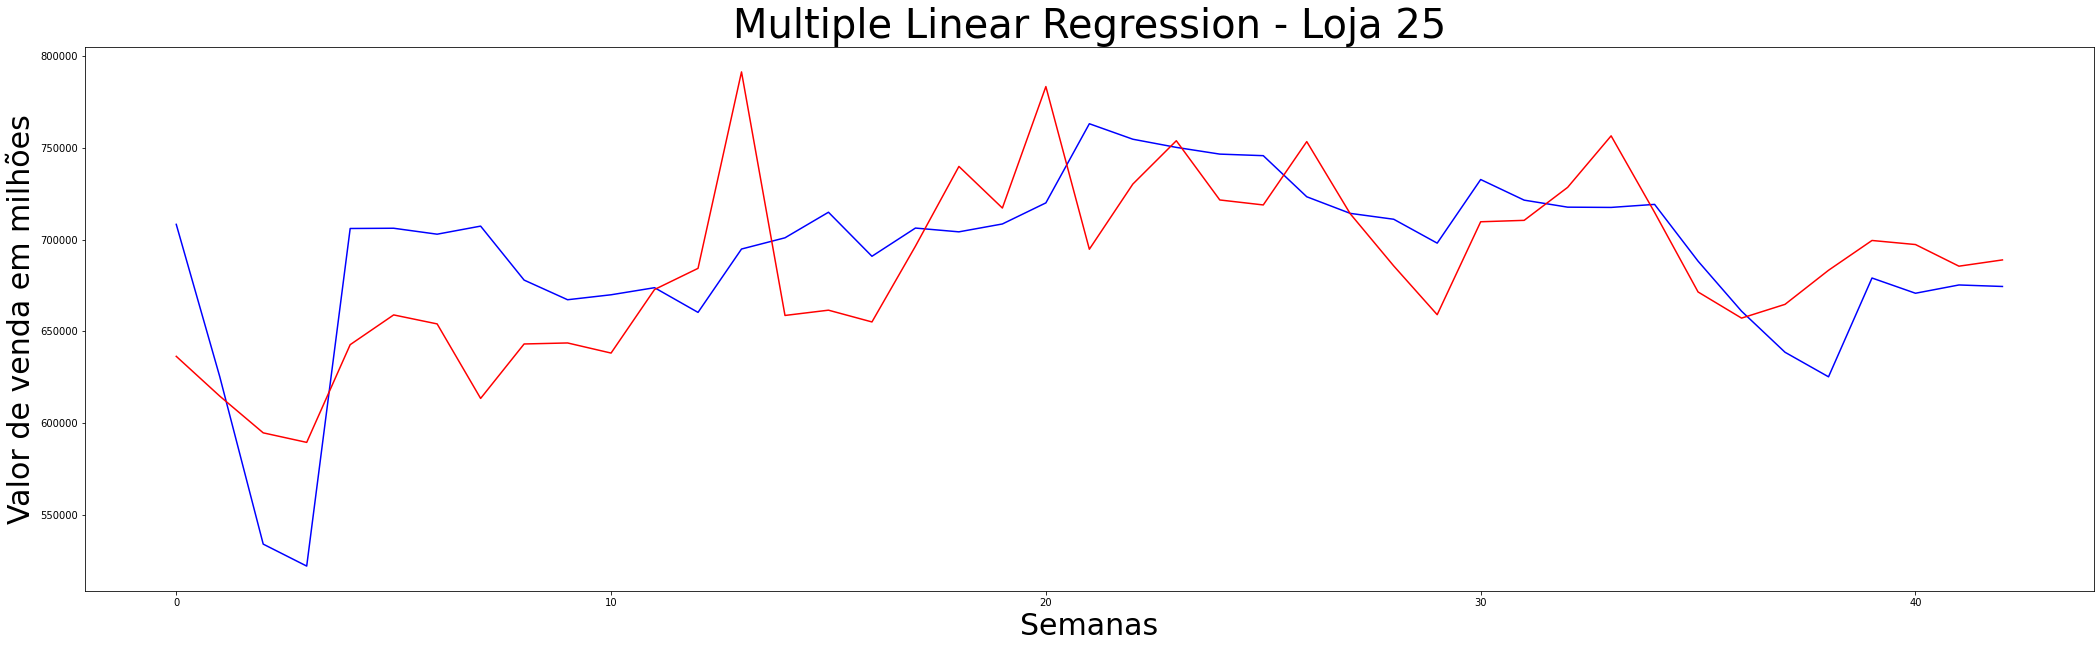

**************************************************
Resultados Loja 26:
48667.754 62718.77


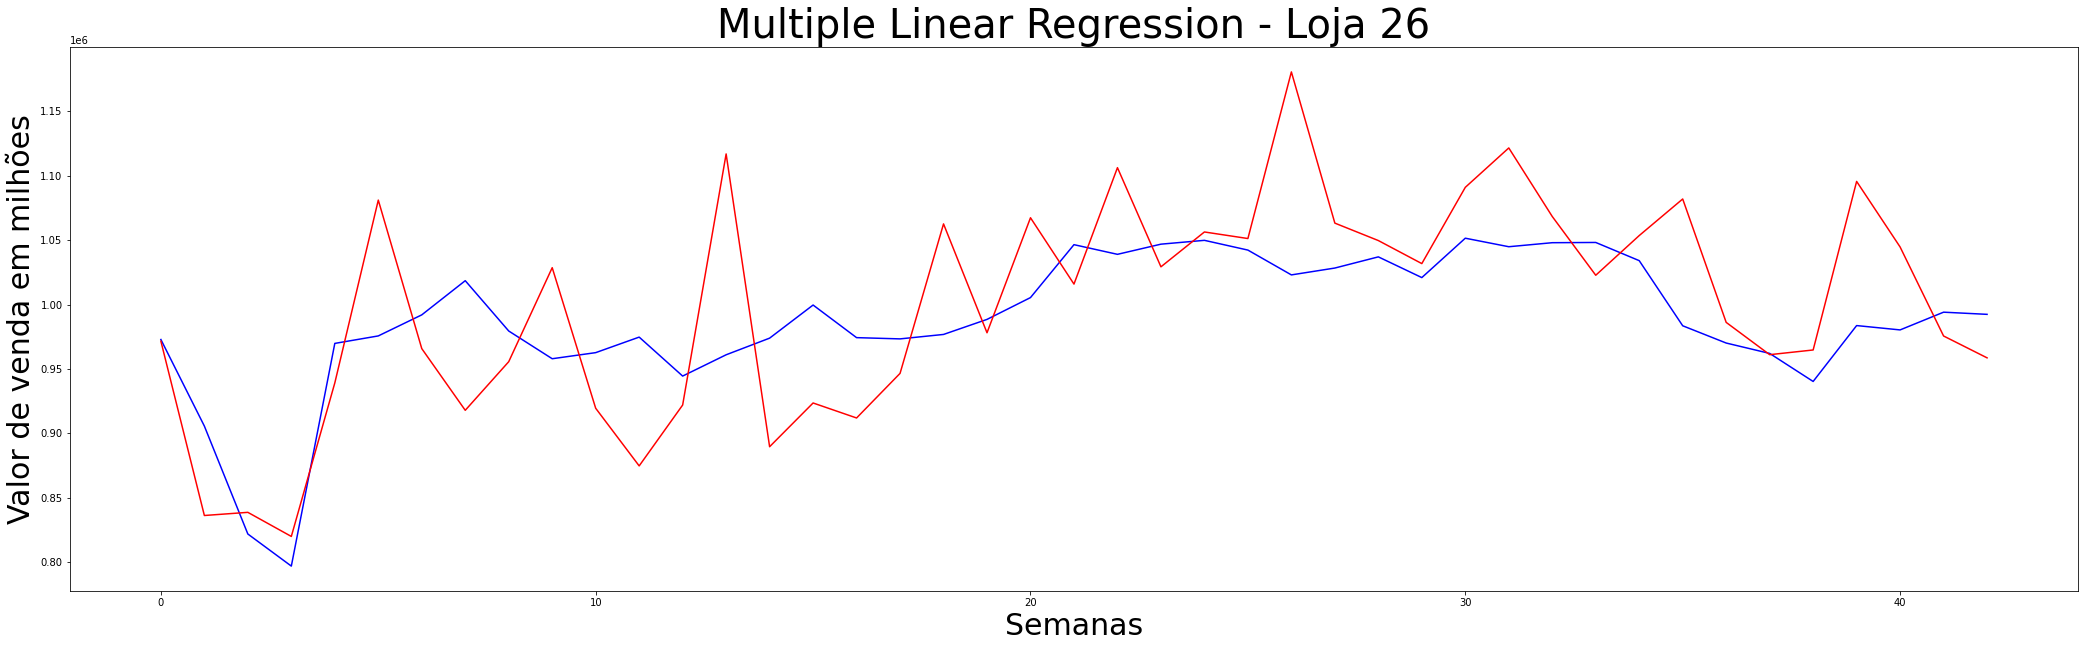

**************************************************
Resultados Loja 27:
100857.09 125551.914


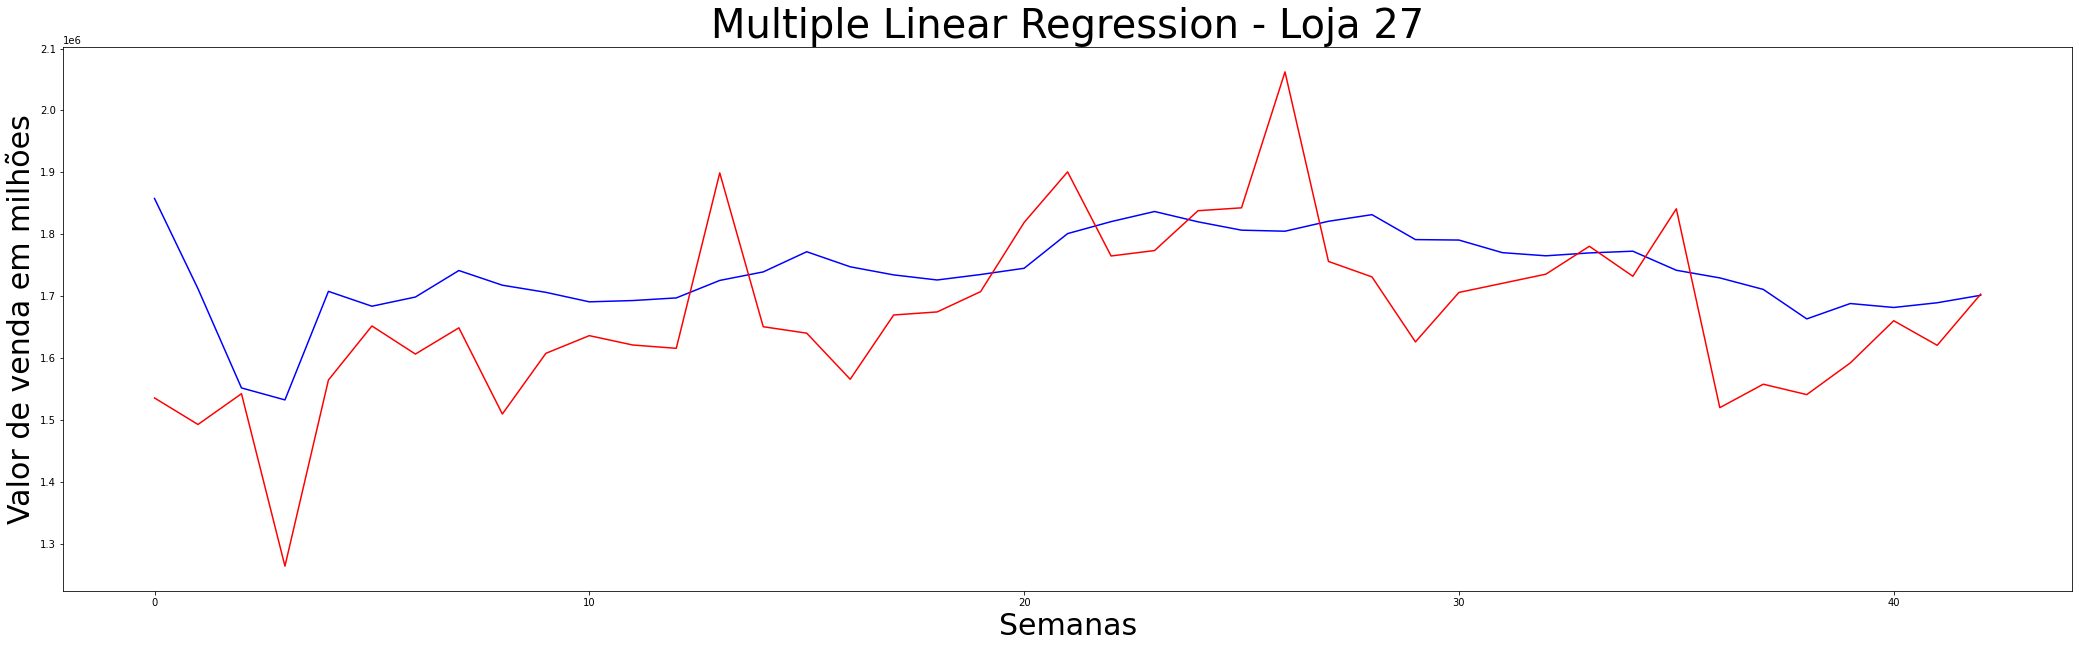

**************************************************
Resultados Loja 28:
148821.8 161976.67


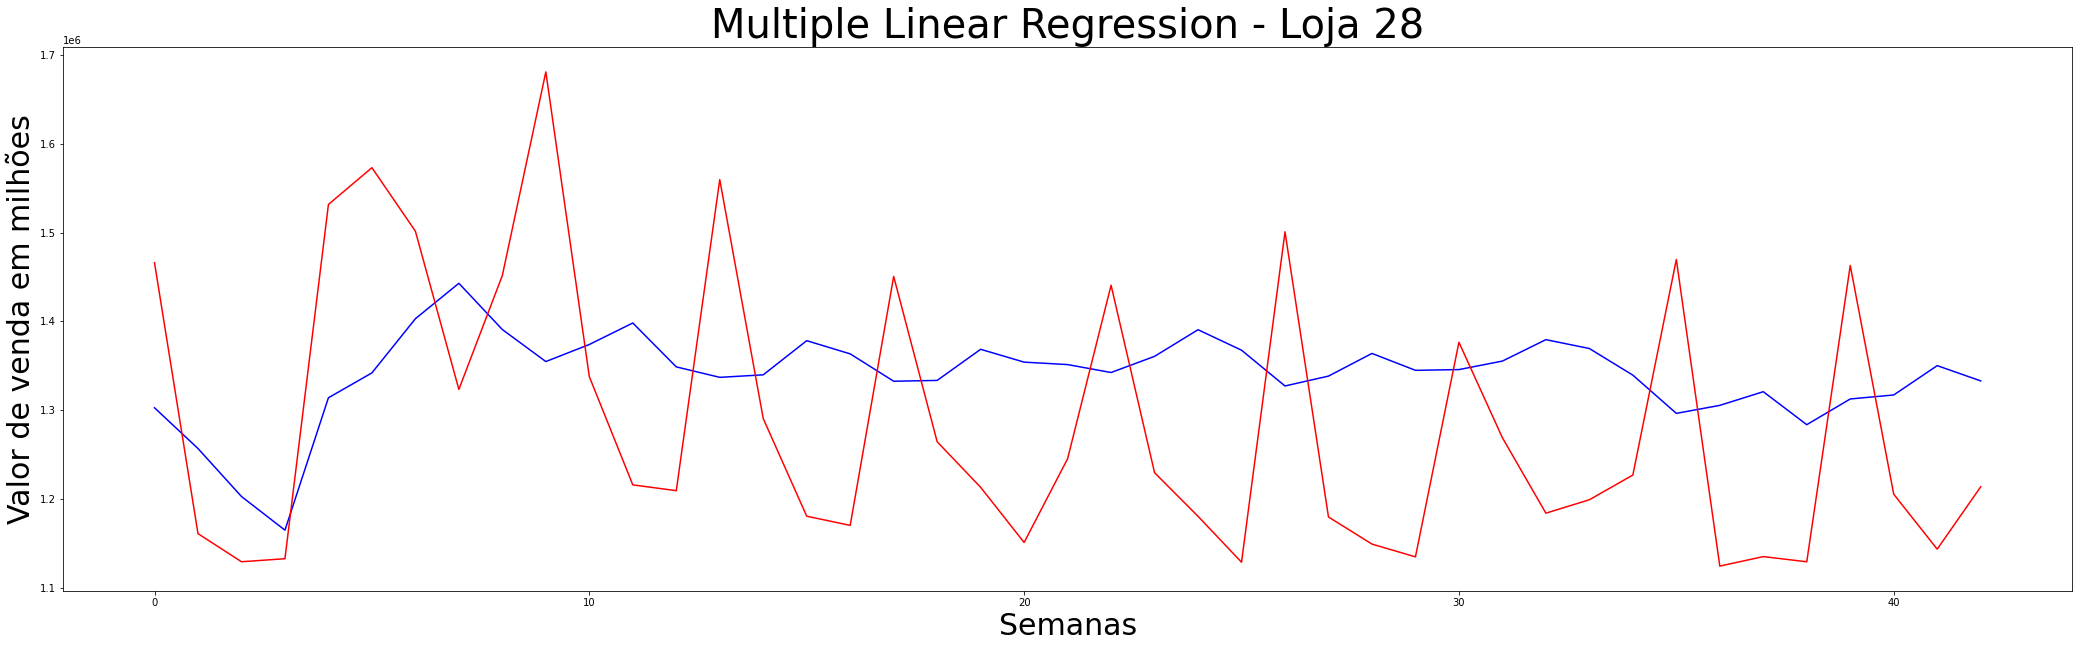

**************************************************
Resultados Loja 29:
31350.775 41371.066


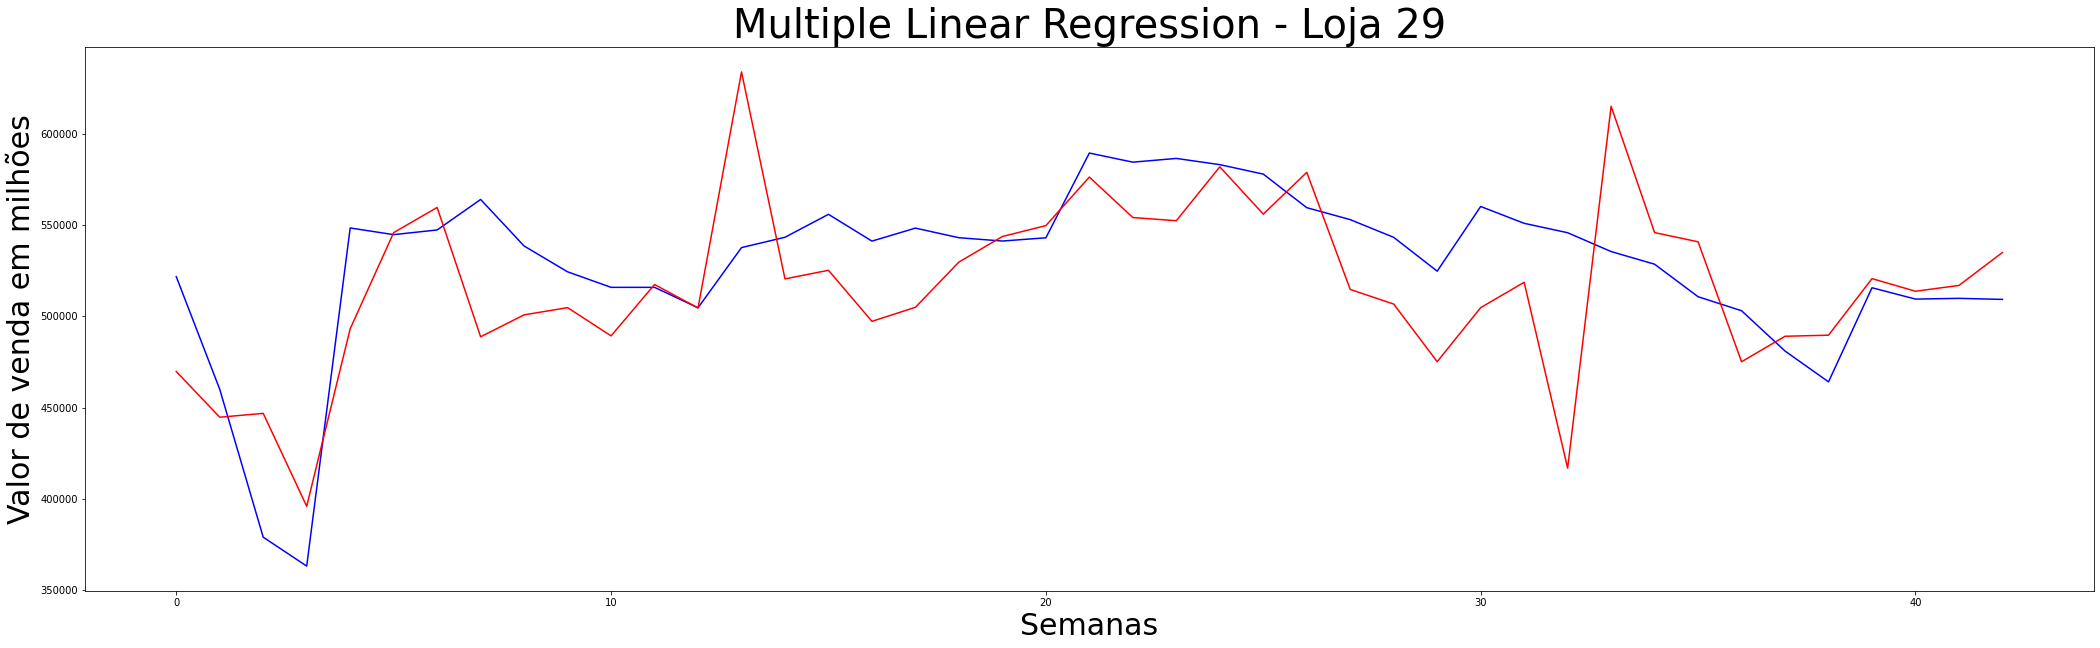

**************************************************
Resultados Loja 30:
37252.234 53431.5


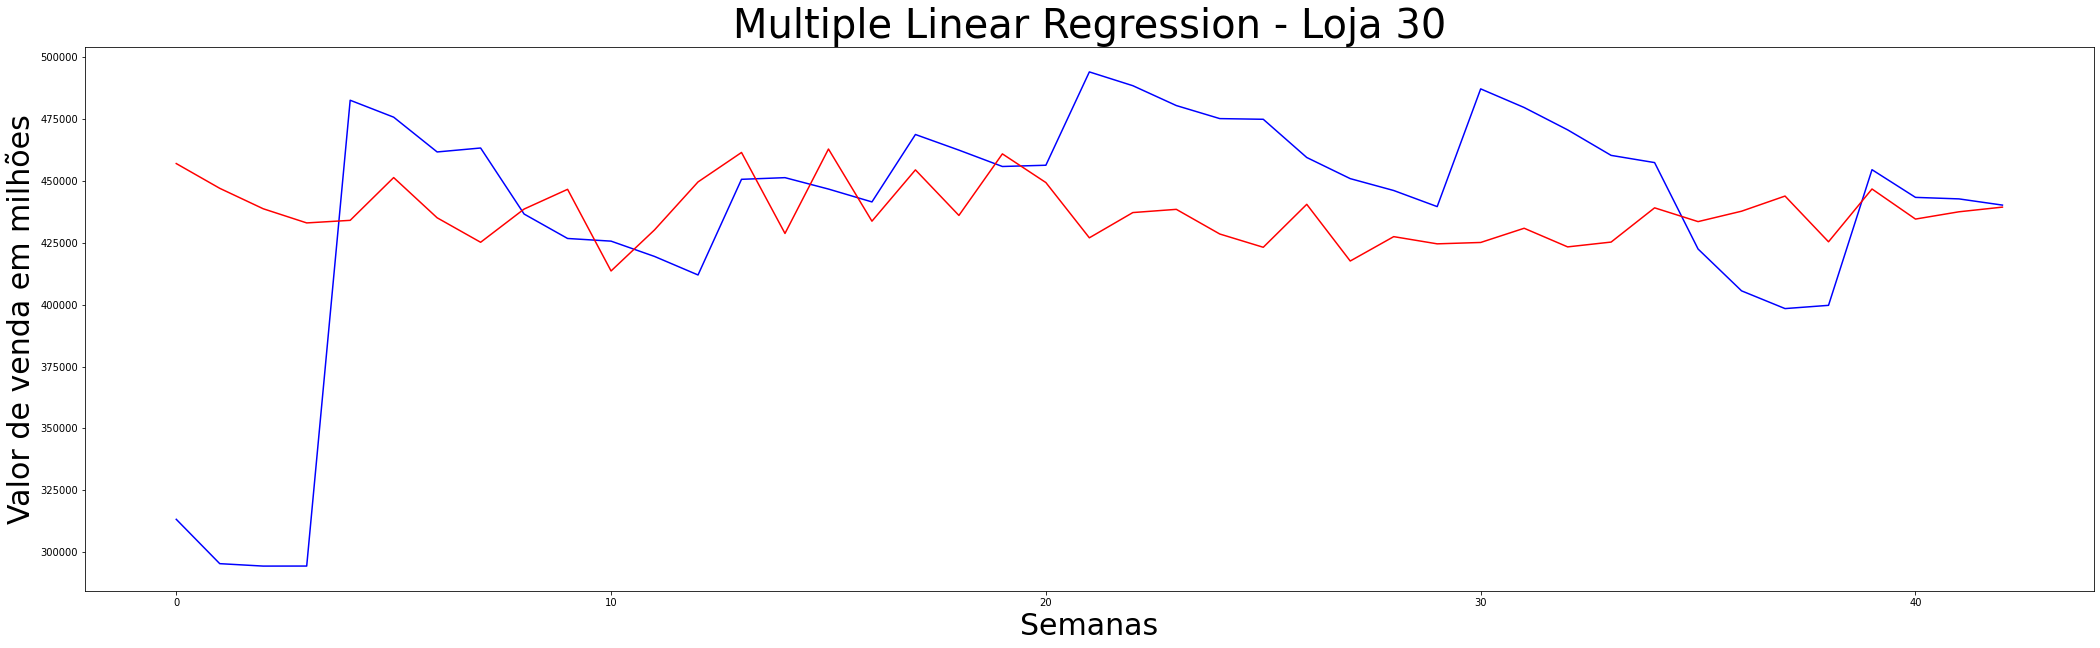

**************************************************
Resultados Loja 31:
45833.61 58092.426


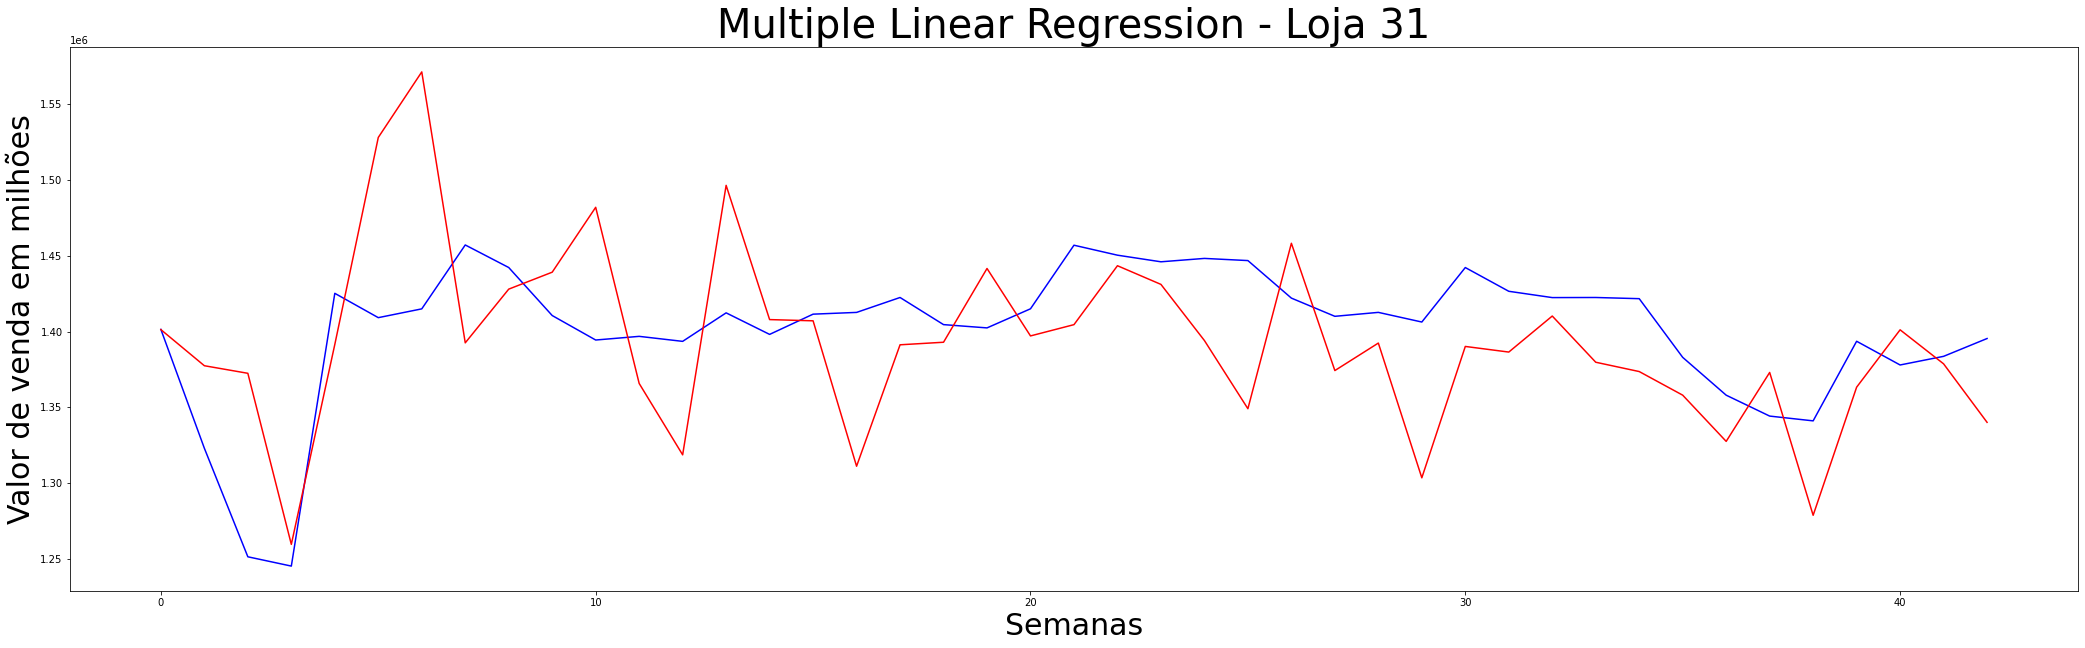

**************************************************
Resultados Loja 32:
39109.84 47489.832


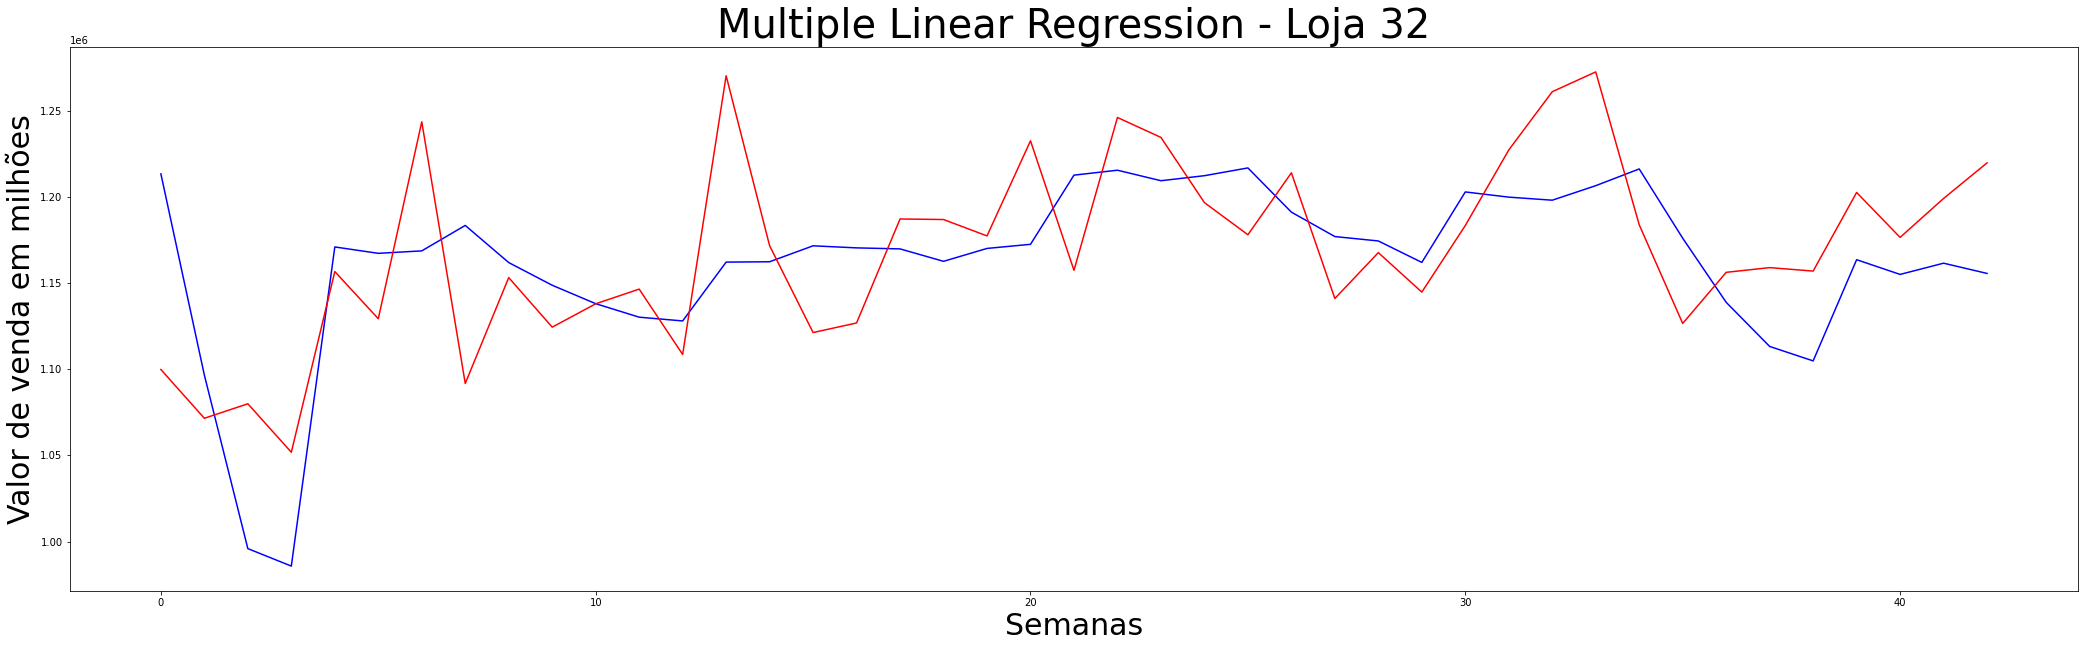

**************************************************
Resultados Loja 33:
36196.094 51439.156


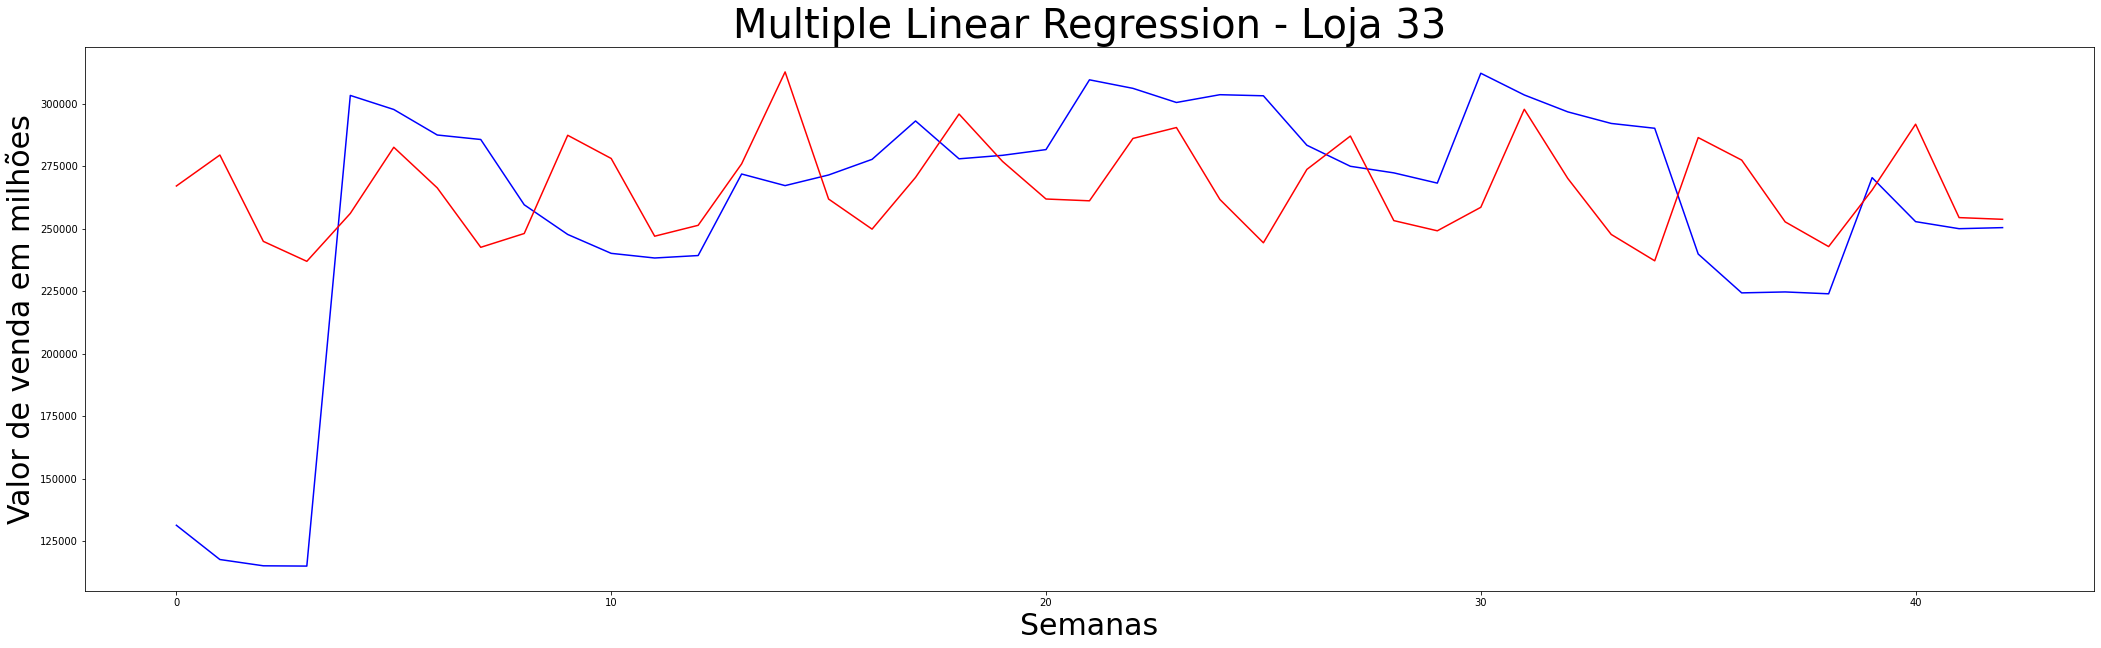

**************************************************
Resultados Loja 34:
35925.215 48997.125


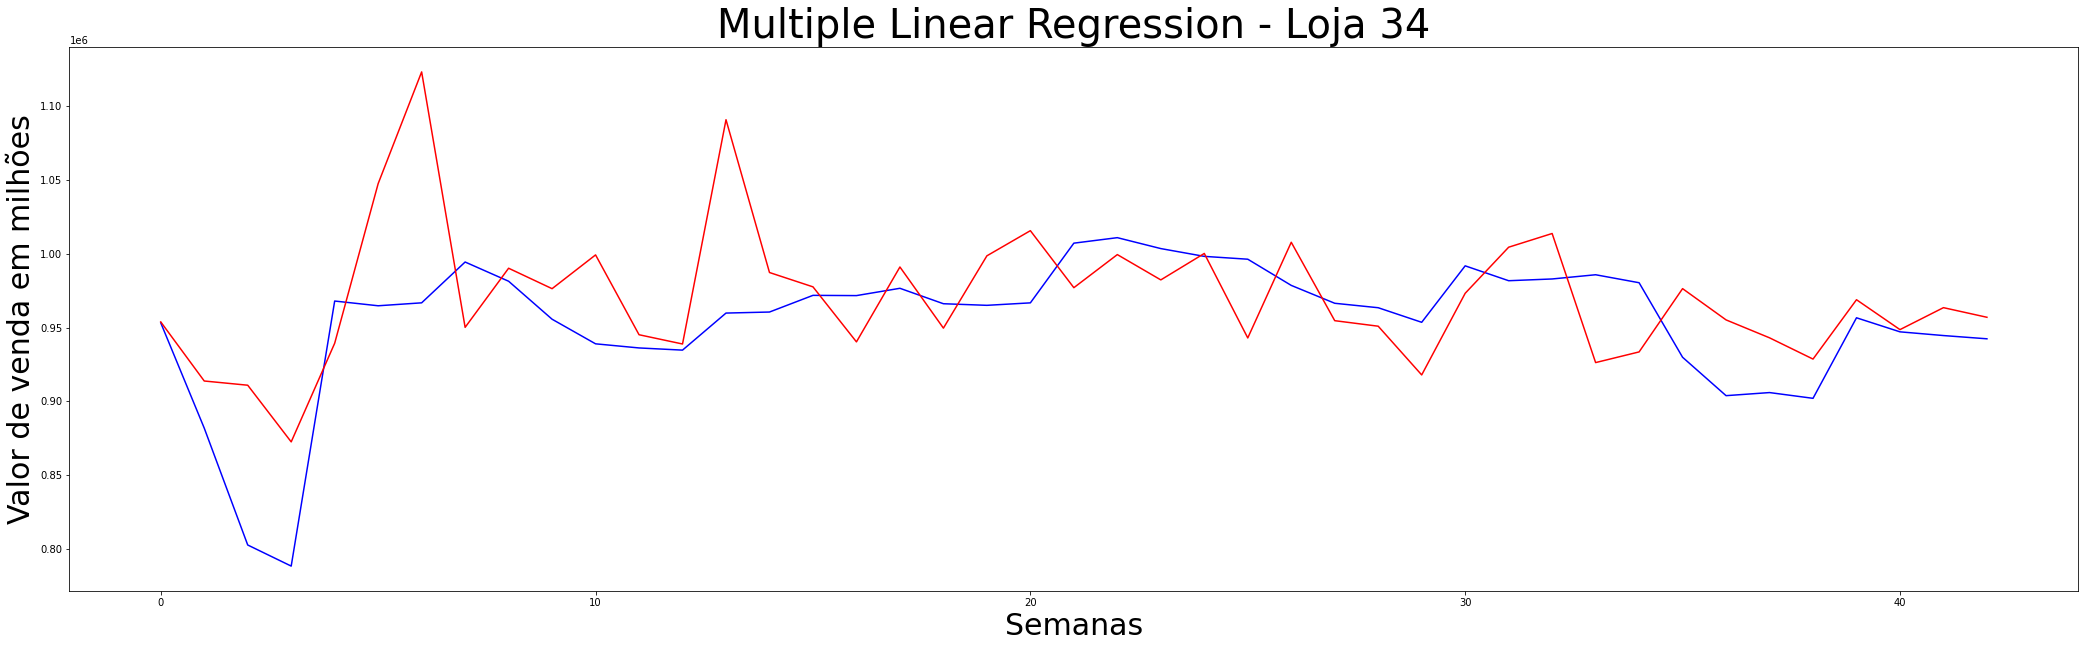

**************************************************
Resultados Loja 35:
69962.77 86361.58


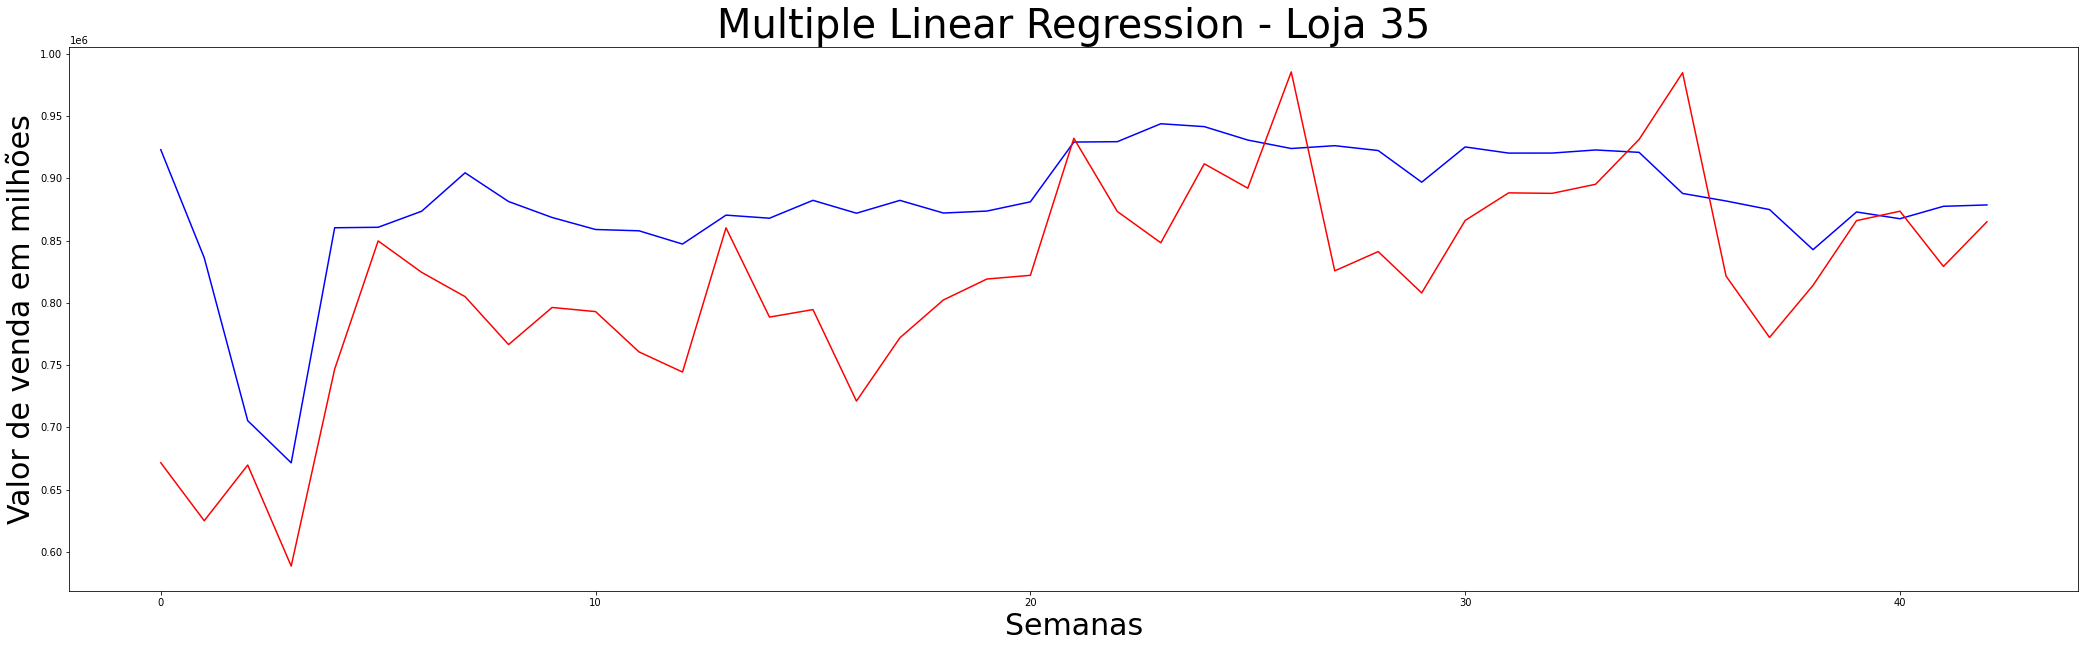

**************************************************
Resultados Loja 36:
76841.75 80785.836


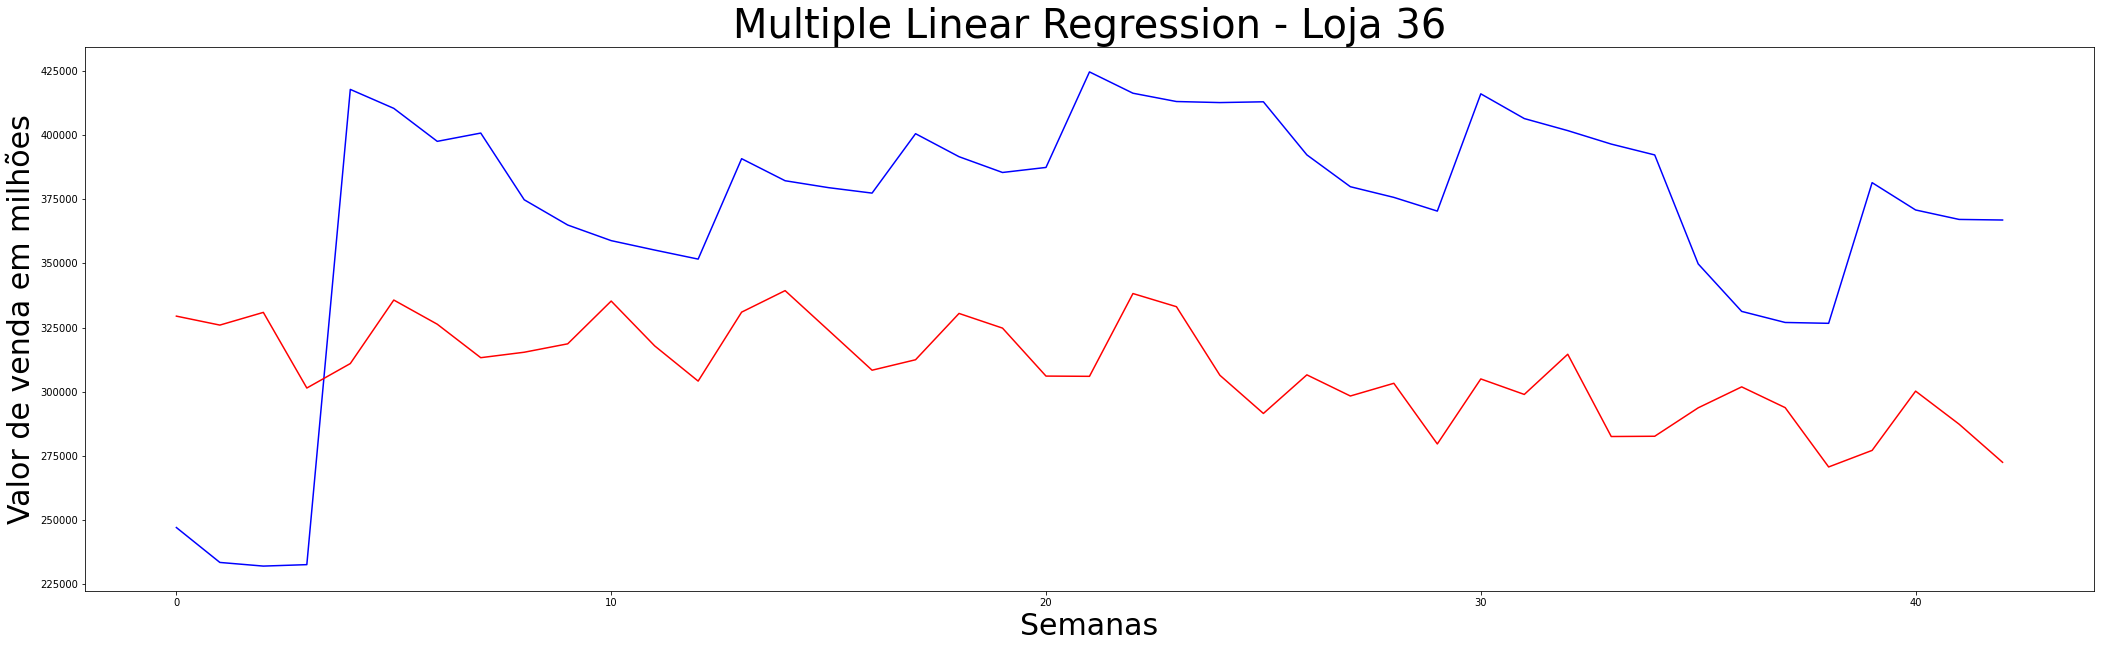

**************************************************
Resultados Loja 37:
37211.31 54912.16


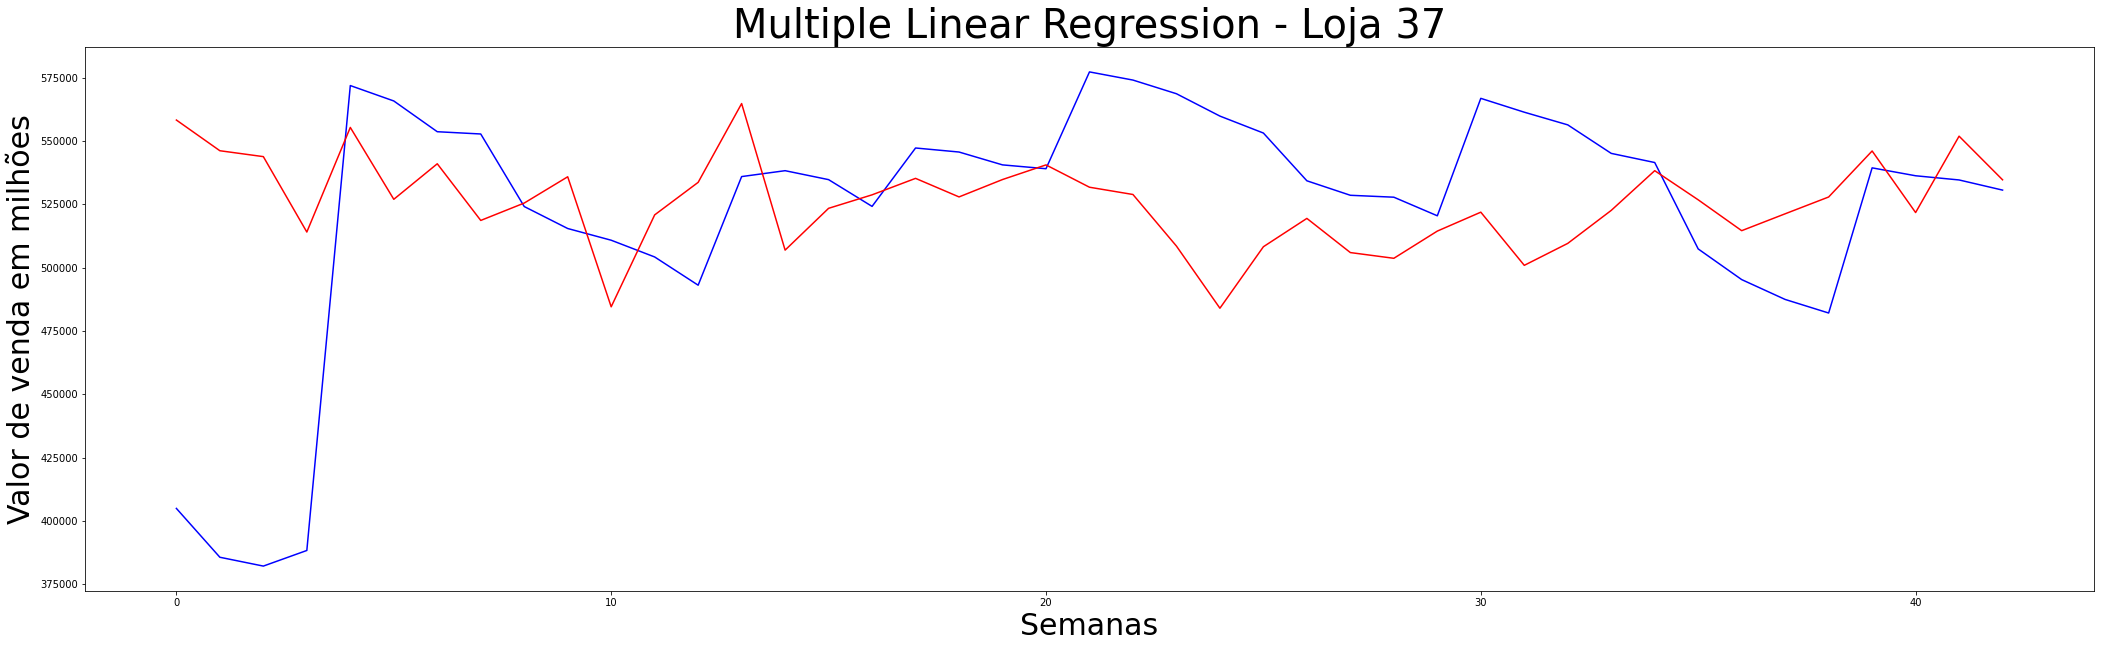

**************************************************
Resultados Loja 38:
43666.68 66208.56


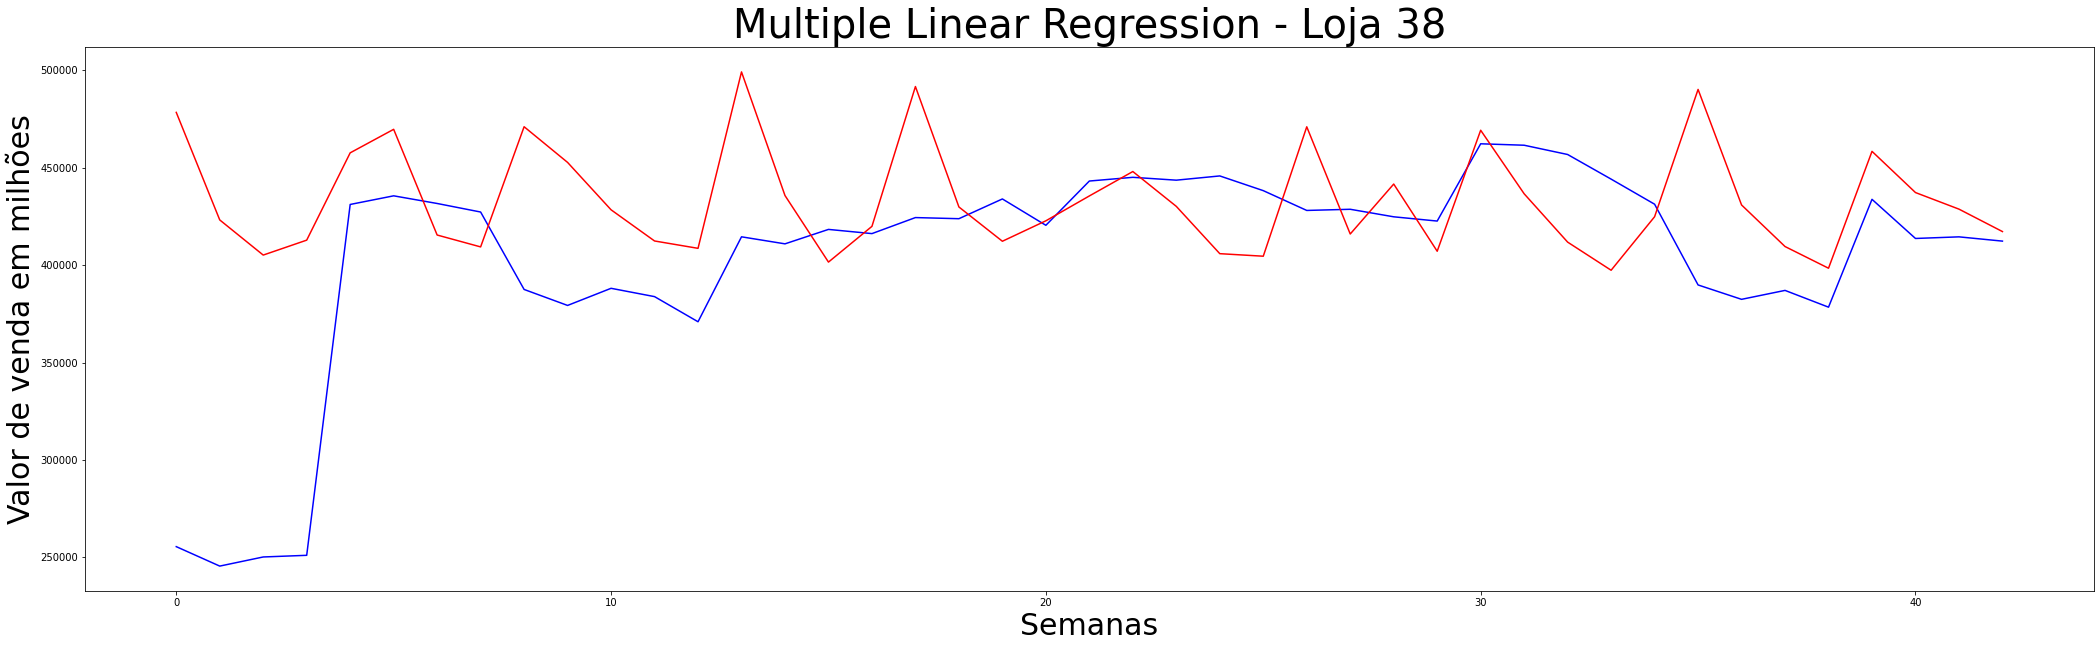

**************************************************
Resultados Loja 39:
80089.36 98998.21


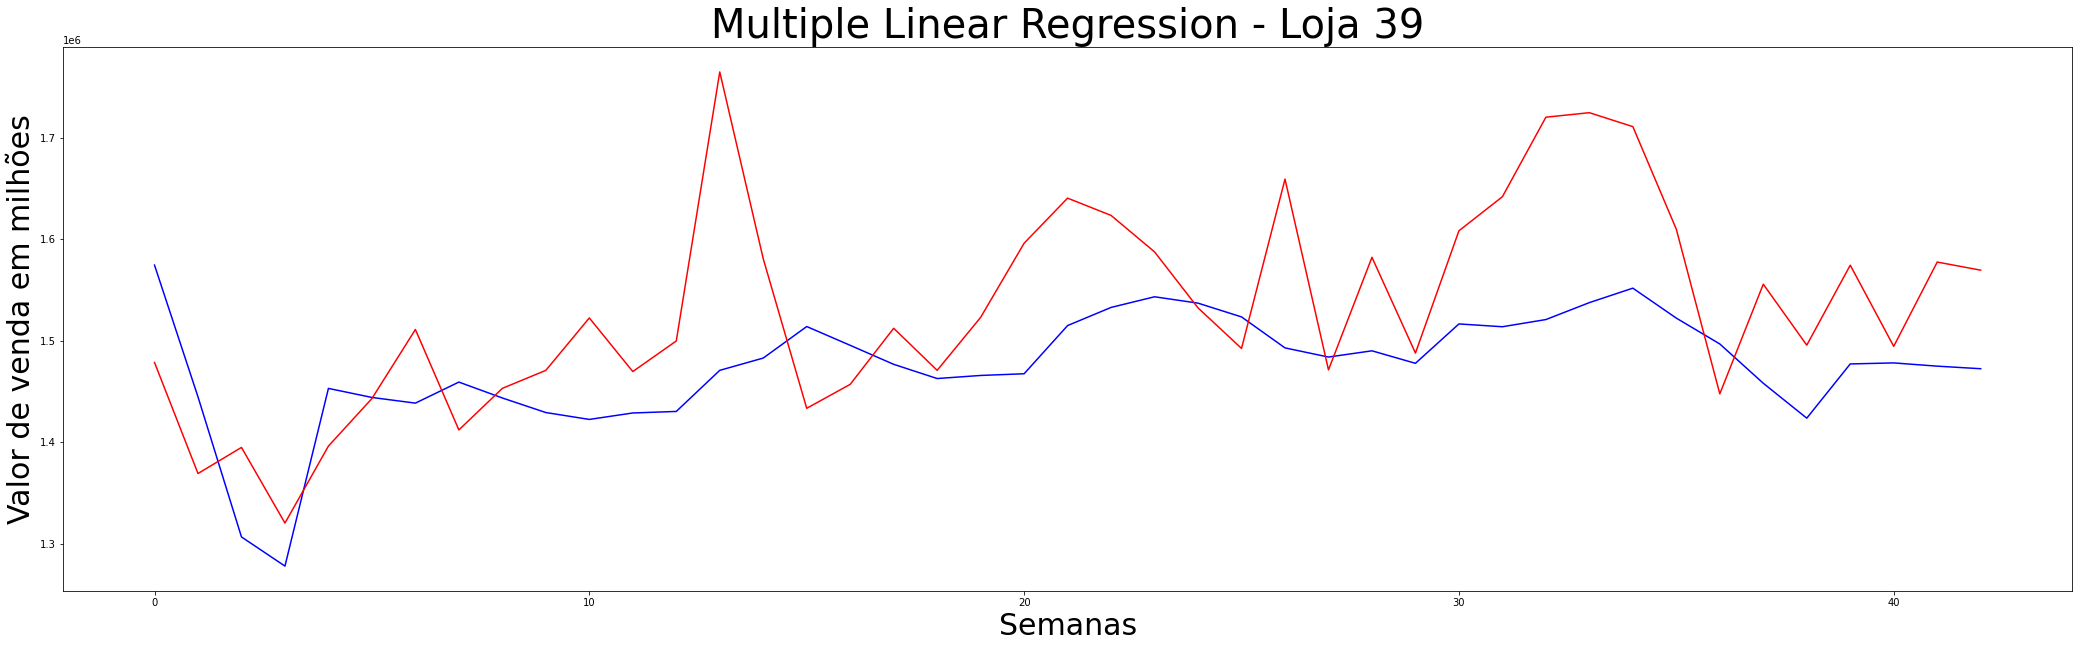

**************************************************
Resultados Loja 40:
51994.977 69432.35


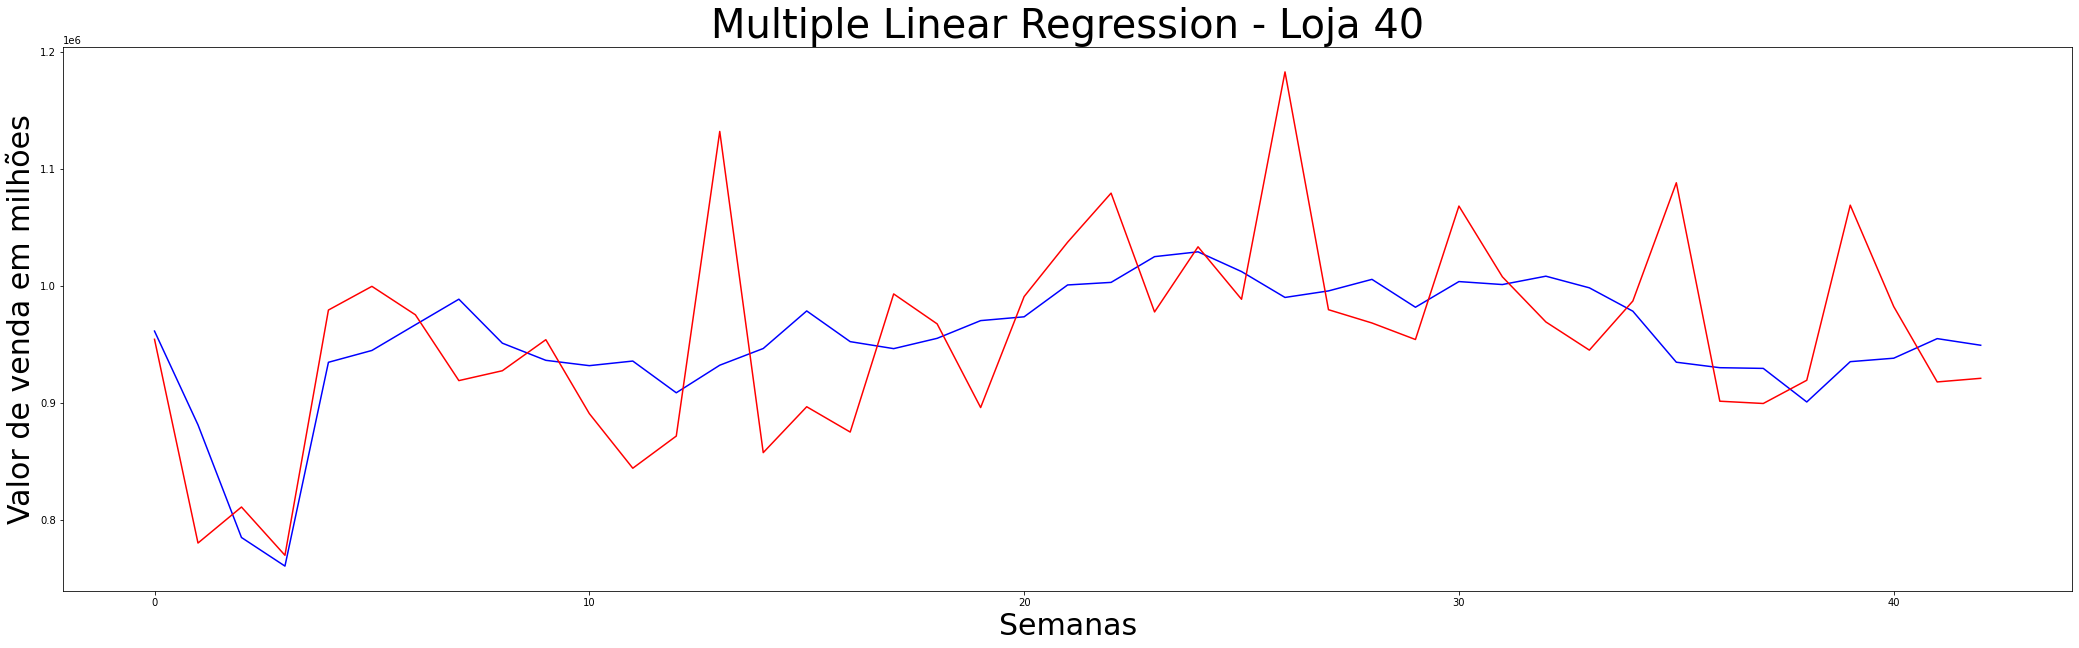

**************************************************
Resultados Loja 41:
73113.41 92360.36


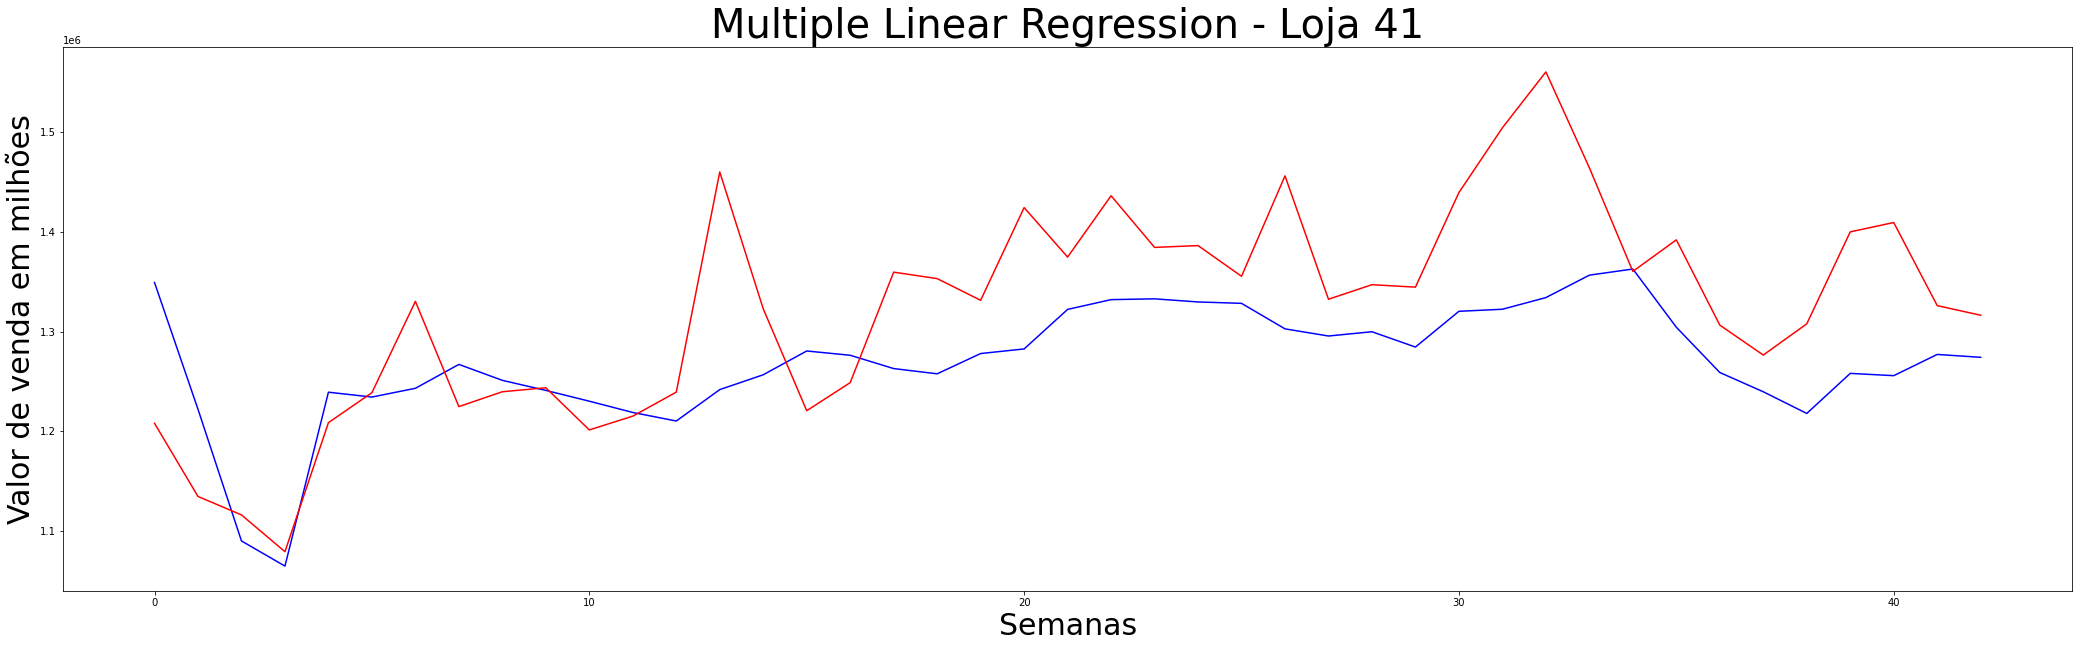

**************************************************
Resultados Loja 42:
58848.977 79099.305


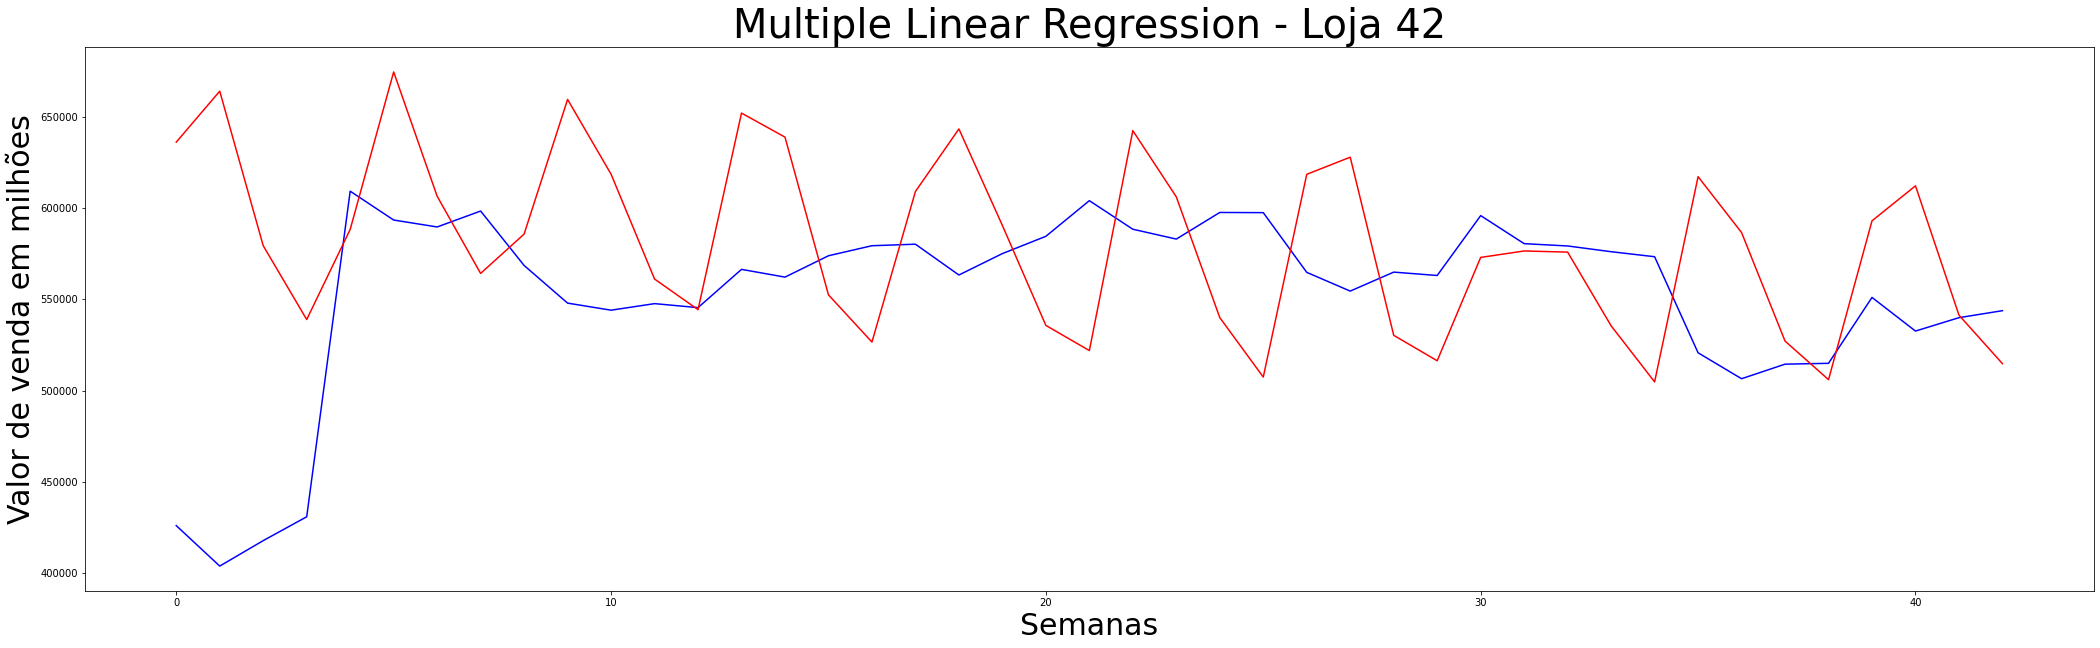

**************************************************
Resultados Loja 43:
39784.117 58478.59


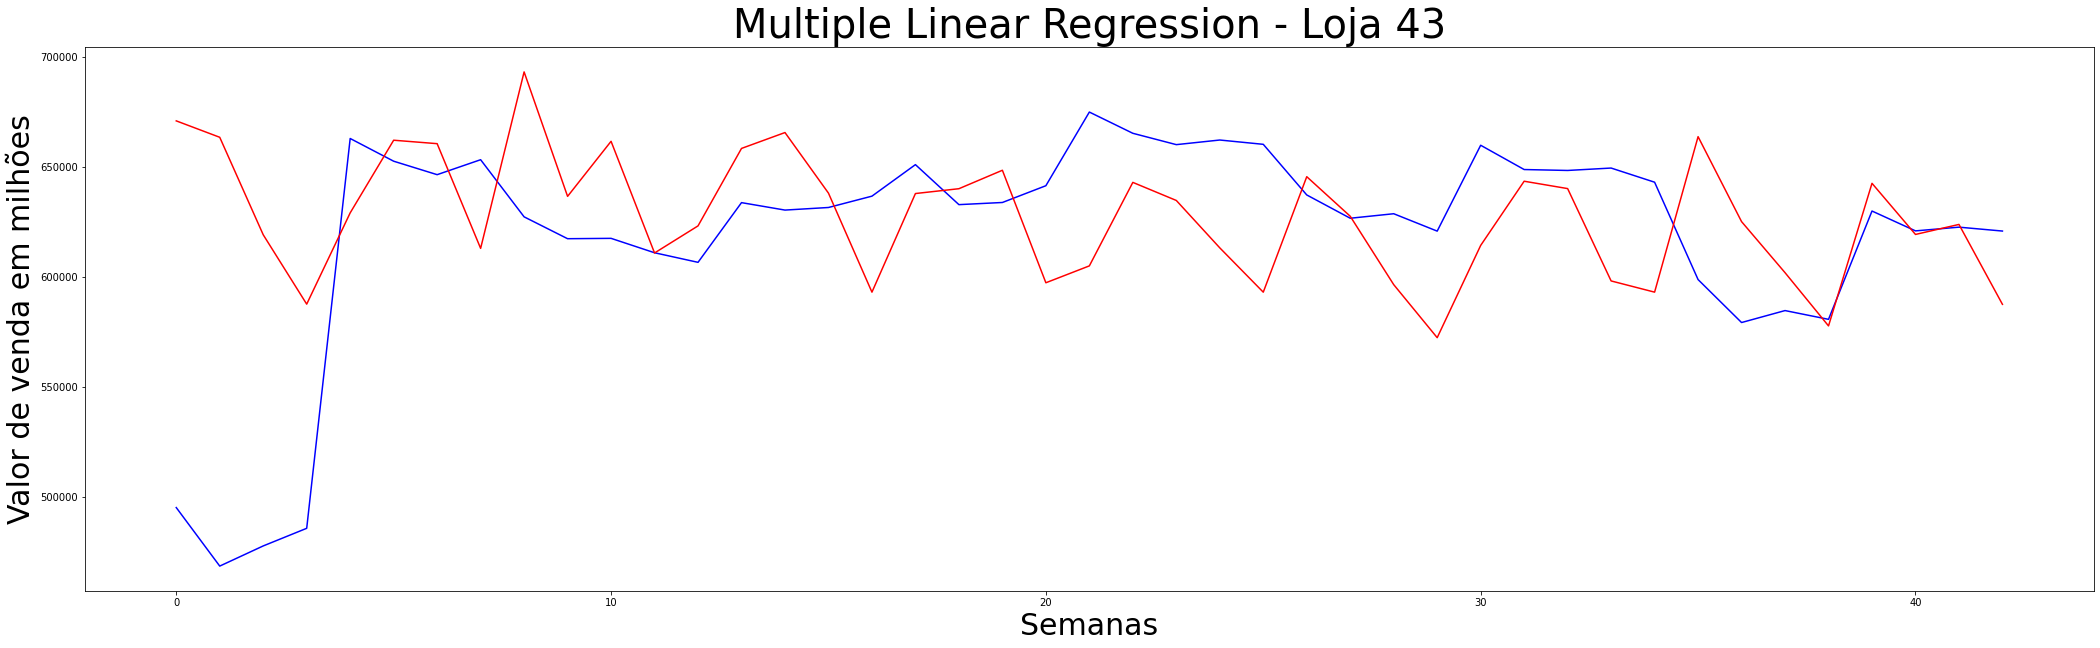

**************************************************
Resultados Loja 44:
33004.746 52394.824


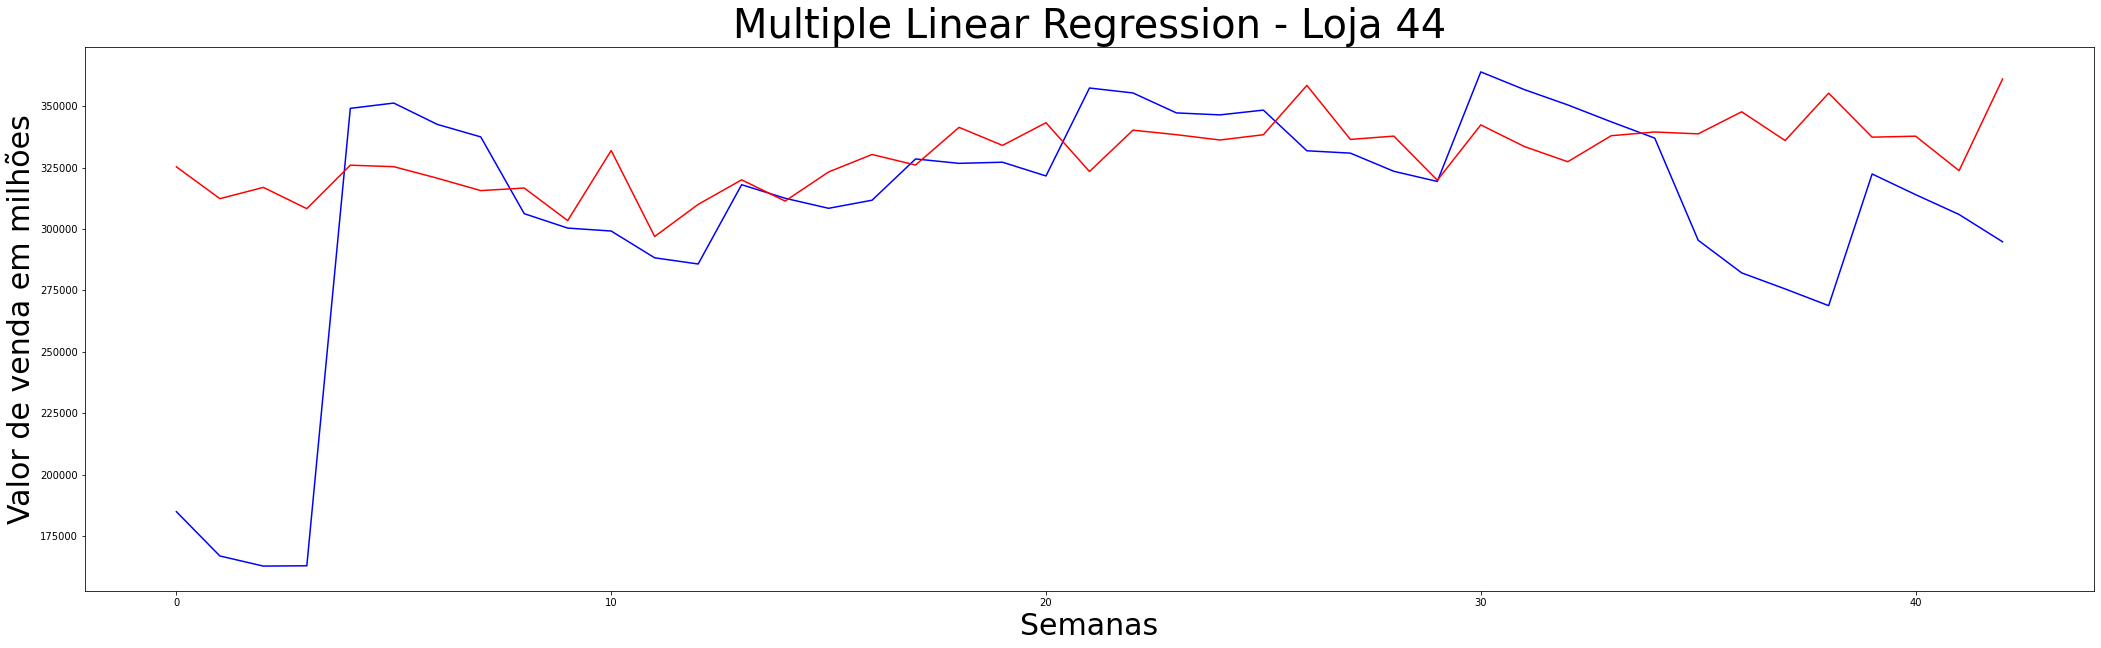

**************************************************
Resultados Loja 45:
34320.324 43648.99


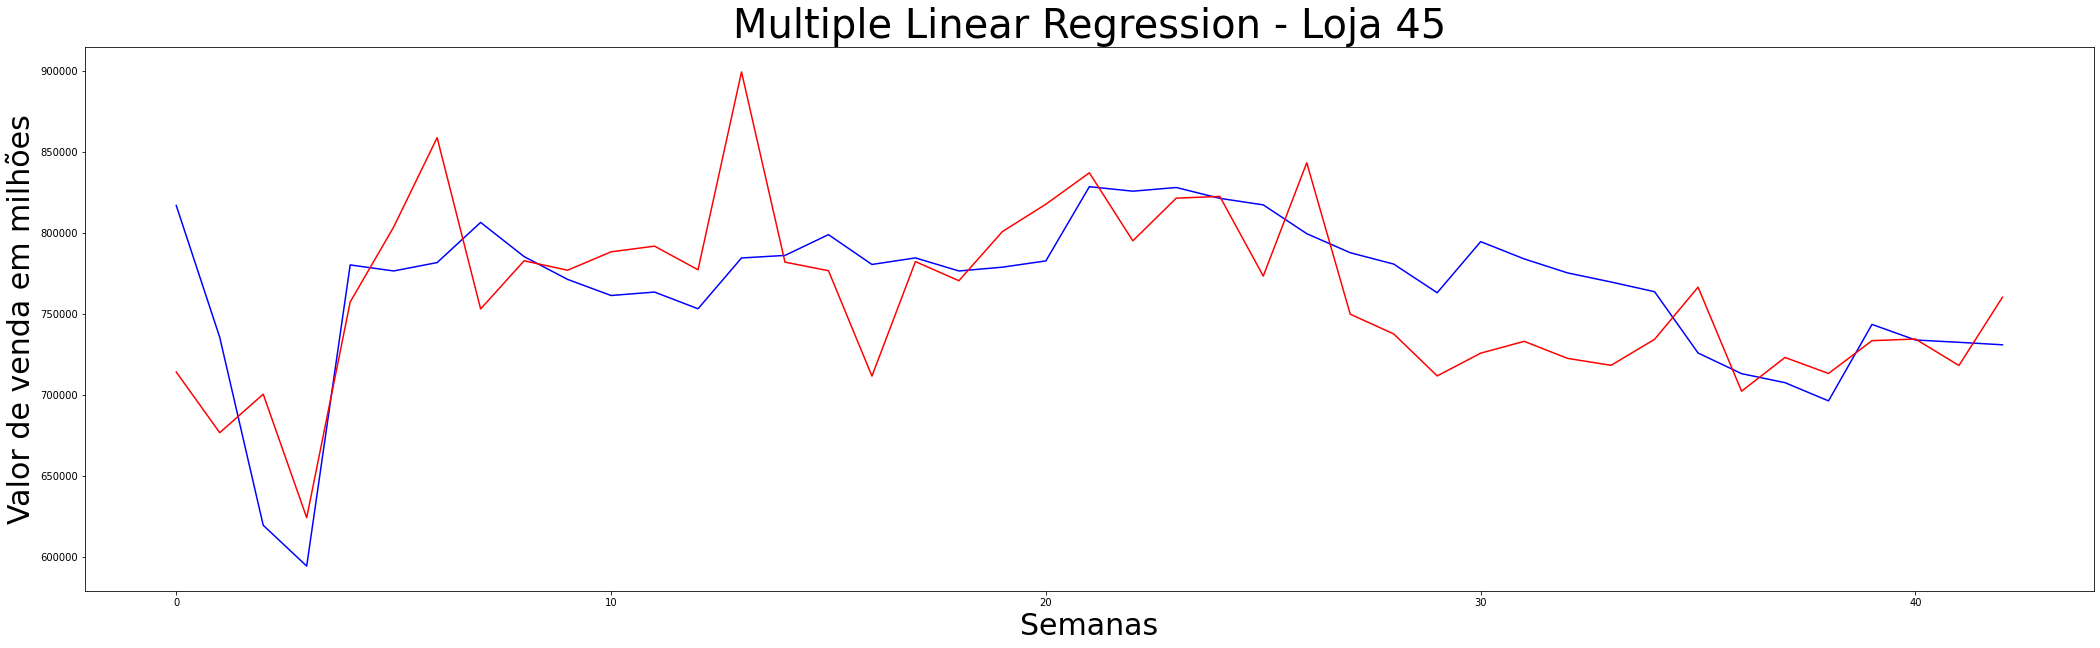

**************************************************


In [36]:
Xy_test = X_test.copy(deep=True)
Xy_test["y"] = y_test.copy()

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = mlr.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Multiple Linear Regression - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
